In [ ]:
# 차트에 한글이 나오게끔 한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


폰트 설치가 끝났으면 런타임을 재시작해서 폰트가 적용되게 하고 다음 셀을 실행하세요.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
import matplotlib.pyplot as plt

# plt.style.use('dark_background')

### ref: 본 ipynb 파일은 다음 웹사이트를 참고했습니다.
---

2021.11.09 조준우 (metamath@gmail.com), https://metamath1.github.io 

https://metamath1.github.io/2021/11/11/transformer.html

## 트랜스포머를 공부하는 이유

트랜스포머는 최근 가장 성공적인 모델임에도 불구하고 CNN, RNN에 대한 사전 지식이 전혀 필요없이 이해할 수 있다는 점에서 입문자분들이 꼭 공부하면 좋을 모델이라고 할 수 있습니다. 트랜스포머를 이해하기 위한 사전 지식은 다음 정도로 정리할 수 있습니다. 

- 신경망에서 완전 연결층 
- 소프트맥스 함수
- $\sin$, $\cos$ 함수 기초
- 데이터를 인코딩해서 다시 디코딩하는 개념
- 배치 정규화와 레이어 정규화의 차이
- 임베딩 개념
- 어텐션 개념

앞 네 개 항목은 인공지능에 막 입문한 학습자라도 어느정도 알고 있는 내용이므로 실제로 입문자가 느끼는 추가 학습 부담은 정규화와 임베딩 개념 그리고 가장 핵심인 어텐션이라고 할 수 있습니다. 임베딩에 대해서는 입력을  특정 길이를 가지는 벡터로 바꾼다는 정도만 알아도 전체 내용을 이해하는데 지장이 없습니다. 어텐션에 대해서는 이전 모델인 seq2seq와 그에 대한 어텐션 매커니즘을 알고 있다면 도움이 되지만 몰라도 상관없습니다. 

이렇게 트랜스포머는 완전 연결층에 대한 기본적인 지식만 가지고 바로 학습할 수 있다는 장점에 더불어 최신 모델들의 근간을 이루는 기본 모델을 공부할 수 있다는 추가 장점도 가지고 있습니다. 




## 트랜스포머 개요

![picture](https://drive.google.com/uc?id=1DudF_35VyVpevpsLr7TfVWi6WeC527kc)
Figure 1: The Transformer - model architecture.[[4](https://arxiv.org/abs/1706.03762)]

트랜스포머에 대한 그림 중 가장 유명한 그림이 바로 위 그림입니다. 이 그림은 처음 보면 아주 복잡하게 보이지만 트랜스포머를 이해하고 보면 간결하게 모델의 핵심을 잘 설명하고 있다는 것을 알게 됩니다. 이 그림을 통해서 먼저 트랜스포머에 대한 전체 맥락을 알아보겠습니다. 트랜스포머가 적용되는 상황은 기계번역, 즉 입력으로 영어 문장이 들어가서 출력으로 한국어 문장이 나오는 상황을 가정하겠습니다. 그러면 위 그림은 다음과 같은 순서로 데이터가 처리되는 것을 이야기하고 있습니다.

1. 입력(Input)이 임베딩 층으로 입력되어 문장의 각 단어들이 적당한 벡터로 변환된다.
2. 이 변환된 벡터가 위치 인코딩Positional Encoding이라는 것으로 부터 출력된 단어의 위치 정보를 가지는 벡터와 더해진다.
3. 2에서 만들어진 벡터가 멀티 헤드 어텐션Multi-Head Attention이라는 층으로 입력되는데 이 때 같은 입력을 키key, 쿼리query, 벨류value로 넣어준다. 
4. 멀티 헤드 어텐션 층을 거쳐 출력된 벡터가 멀티 헤드 어텐션 층으로 입력되기 전 벡터와 더해지고(ResNet의 스킵커넥션) 레이어 정규화 된다.
5. 4의 출력을 Linear 레이어에 입력하여 출력을 만든다. 
6. 5의 출력과 4의 출력을 더하고 레이어 정규화 한다. (또 한번 스킵커넥션)
7. 6에서 출력된 결과를 입력으로 3으로 돌아가 다시 반복한다. 이렇게 N번 반복한다.

여기까지가 트랜스포머의 인코더에 해당되는 내용입니다. 다음은 디코더에 대한 내용입니다.

1. 입력과 쌍이 되는 정답을 디코더에 입력한다.
2. 인코더와 마찬가지로 정답에 대해서 인코더의 1, 2 과정을 거친다.
3. 이렇게 만들어진 벡터를 인코더의 3번, 4번 과정과 동일하게 어텐션한다. 단, 이때 마스크를 씌우게 되는데 이 마스크를 씌우는 부분이 트랜스포머를 이해하는 난관 중 하나입니다. 구체적인 세부 사항은 코드와 함께 설명하겠습니다. 여기서는 일단 어텐션 한다고 생각하면 되겠습니다.
4. 3의 출력으로 다시 한번 어텐션하는데 이때는 키, 벨류는 인코더의 출력으로 설정하고 쿼리를 앞 3번 과정의 출력으로 설정하여 어텐션 한다. 
5. 4의 출력을 입력으로 Linear 레이어를 통과하고 스킵커넥션, 레이어 정규화를 적용한다.
6. 5의 출력을 입력으로 3으로 돌아가 다시 반복한다. 이렇게 N번 반복한다.

마지막으로 디코더의 내용으로 부터 클래스의 확률을 계산하는 부분은

1. 디코더에서 6의 출력을 Linear층으로 입력한다.
2. 1의 출력을 Softmax층으로 입력하여 클래스에 대한 확률을 계산한다.

이고, 이것이 트랜스포머의 가장 핵심적인 내용입니다. 알고 보면 별것 아닌 내용인데 처음 공부하려면 꽤 복잡해 보이기도 한 것이 사실입니다. 

여기서 주의해야할 점은 트랜스포머에 입력은 타임스탭별로 하니씩 입력되지 않고 모든 타임스탭의 입력이 동시에 입력되고 출력도 마찬가지라는 점입니다. 예를 들어 다음과 같은 입력이 있을 때

`<start>` `I` `don't` `know` `what` `you` `mean` `<end>`

입력의 일곱개 단어가 모두 한번에 입력되고 여기에 대한 정답이 다음과 같을 때 

`<start>` `나는` `니가` `의미하는` `바를` `모르겠다` `<end>`

디코더의 입력으로는

`<start>` `나는` `니가` `의미하는` `바를` `모르겠다`

이 들어가고 출력으로는 

`나는` `니가` `의미하는` `바를` `모르겠다` `<end>`

가 나오기를 기대하는 것입니다. 물론 RNN을 사용한 seq2seq같은 모델을 아예 모르는 초심자라면 이런 내용에 주의를 할 필요 조차 없습니다. 그냥 입력이 문장 통째로 들어가서 출력이 문장 통째로 나온다고 생각하면 됩니다.

이제 코드를 보면서 그림의 순서대로 따라가봅시다.

## Embedding

트랜스포머에 입력 데이터인 단어를 입력하기 위해서는 단어에 대해 두가지 전처리를 거쳐야 하는데 하나는 임베딩이고 다른 하나는 위치 인코딩입니다. 모델에 단어를 입력할 때 단어를 숫자로 바꿔서 입력하게 되는데 이 때 가급적 목적하는 작업에 도움이 되도록 바꿔야 할 것입니다. 단어-숫자 변환을 최종 작업에 도움이 되는 방향으로 하기 위해 임베딩embedding이라는 층을 사용하게 됩니다. 임베딩 층은 단어를 입력받아 적절한 숫자 벡터로 변환하는 층으로 변환되어 출력되는 벡터의 길이를 코드에서 `d_model`로 표시합니다.

임베딩층이 하는 일은 원핫인코딩된 입력벡터를 적절한 밀집벡터로 바꿔주는 것으로 다음처럼 작동합니다.<sup>&#8224;</sup> 

$$
\mathbf{x}_{\text{emb}}=\mathbf{x}W_{\text{emb}}
$$

여기서 임베딩 층이 가지는 가중치 행렬 $W_{\text{emb}}$의 크기는 $(\text{vocab}, d_{\text{model}})$이 되고 입력 벡터 $\mathbf{x}$는 길이가 $(1, \text{vocab})$인 원핫인코딩된 벡터입니다. 따라서 임베딩 층의 가중치 행렬은 특정 단어에 해당하는 $d_{\text{model}}$차원의 벡터를 행으로 가지고 있는 룩업 테이블이라고 할 수 있습니다. 다음 그림처럼 단어장에서 단어의 순번을 가지고 변환될 벡터를 찾는 것입니다.

![picture](https://drive.google.com/uc?id=1ajCVDKg_c8XQyZFUPr3kuAu3bFRnjAcG)

그림을 보면 제일 먼저 'prime'이란 단어를 단어장에서 몇번째 단어인지 찾습니다. 그렇게 찾은 단어의 순번 자리만 1이 되고 나머지는 다 0인 전체 단어 개수만큼 요소를 가지는 원핫벡터를 만듭니다. 이 원핫벡터를 $W_{\text{emb}}$에 행렬곱해서 임베딩 벡터를 얻는 것입니다.<sup>&#8224;&#8224;</sup>  이렇게 임베딩 층을 거치면 입력이 길이 $d_{\text{model}}$인 벡터로 변환됩니다.

---
<sup>&#8224;</sup>  [1]에서는 가중치 행렬 $W$의 행수를 입력, 열수를 출력으로 적고 입력 $\mathbf{x}$를 행벡터로 하여 $W$ 앞에서 곱하는 방식을 쓰고 있습니다. 다른 표현을 예로 들어보면 파이토치에서는 행벡터와 가중치 행렬의 곱을 $\mathbf{x} W^{T}$로 표현을 합니다. 여기서 $W$는 행수를 출력, 열수를 입력으로 하고 있는 행렬이 됩니다. 개인적으로 가장 선호하는 방식은 가중치 행렬을 파이토치 형태로 쓰고 열 벡터 $\mathbf{x}$를 뒤에서 곱하는 $W \mathbf{x}$ 방식입니다.

<sup>&#8224;&#8224;</sup>실제로는 이렇게 행렬곱하지 않습니다. 그냥 $W_{\text{emb}}$에서 'prime'이라는 단어 인덱스에 해당하는 행을 가져옵니다.

In [3]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        # 임베딩 벡터에 sqrt(d_model)을 곱해서 임베딩 벡터의 요소들 값을 
        # 증가 시킴.
        # d_model은 512정도 되는 큰 값이이므로 22정도 되는 값이 
        # 임베딩 벡터 요소에 곱해짐. 
        # 곱하는 이유는 뒤에 포지션 벡터를 더할텐데 이 때 포지션 벡터에
        # 의해 임베딩 결과가 희석되는 것을 막기 위함
        # ref.: https://stackoverflow.com/questions/56930821/why-does-embedding-vector-multiplied-by-a-constant-in-transformer-model
        return self.lut(x) * math.sqrt(self.d_model)

코드는 파이토치 `nn.Embedding`을 그대로 사용합니다. 단 위 코드에서 임베딩 층을 포워드 시킨 결과에 $\sqrt{d_{\text{model}}}$을 곱하고 있는 점이 좀 특이합니다. 이렇게 상수를 곱하는 이유는 뒤에 설명할 포지션 벡터가 임베딩 벡터에 더해지는데 이 때 포지션 벡터가 더해지면서 임베딩 벡터의 값이 희석되는 것을 막기 위해 임베딩 벡터의 요소 크기를 상대적으로 크게 하기 위함일 것으로 생각됩니다.[[5](https://stackoverflow.com/questions/56930821/why-does-embedding-vector-multiplied-by-a-constant-in-transformer-model)] 이런 해석은 논문에서 공식적으로 밝히고 있는 것은 아닙니다. 논문에서는 그냥 $\sqrt{d_{\text{model}}}$를 곱한다고만 되어 있습니다.

이 과정을 거쳐서 길이 $n_{\text{seq}}$인 입력 문장의 각 단어를 임베딩 벡터로 모두 변환하게 되면 $(n_{\text{seq}}, d_{\text{model}})$인 행렬로 변환되게 됩니다.

## Positional Encoding

앞서 이야기한 위치 인코딩입니다. 트랜스포머는 RNN같은 순차적 구조를 사용하지 않고 문장 전체를 한꺼번에 입력하여 문장에 있는 단어간 관계를 특징화하는 모델입니다. RNN은 토큰이 순차적으로 입력되므로 토큰 순서 정보가 자연스럽게 생겨나는 반면 트랜스포머는 토큰의 순서 정보를 인위적으로 만들어 넣어줄 필요가 있습니다. 순서 정보를 인위적으로 만들기위해 논문 저자들은 위치 인코딩이라는 방법을 사용합니다. 

$$
PE_{(pos,2i)}=\sin \left( \frac{pos}{10000^{2i/d_{\text{model}}}} \right)
$$

$$
PE_{(pos,2i+1)}=\cos \left( \frac{pos}{10000^{2i/d_{\text{model}}}} \right)
$$

위 식을 사용하여 입력 문장의 위치 정보를 $(n_{\text{seq}}, d_{\text{model}})$인 행렬로 인코딩 합니다. 식을 보면 행은 단어의 위치를 나타내는데 단어 위치별 값은 $pos$ 변수에 의해 달라집니다. 열에 대해서는 홀수 열은 $\cos$함수로 짝수 열은 $\sin$함수를 사용해서 값을 다르게 계산하는데 열 인덱스 $i$에 대해서 각각 다른 주기(첫 두 열부터 $2 \pi$ 주기에서 시작해서 마지막 두 열에서는 거의 $10000 \times 2 \pi$ 주기를 가짐) 의 삼각함수를 사용하여 모든 열에 대해서 다른 값을 계산하게 됩니다.

문장 길이 120에 `d_model=512`인 경우 위치 인코딩을 직접 해보면 다음과 같습니다.


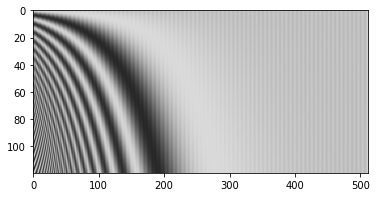

In [4]:
seq_length = 120
d_model = 512

PE = np.zeros((seq_length, d_model))

for pos in range(seq_length):
    for i in range(d_model//2):
        PE[pos, 2*i]   = np.sin( pos / (10000**(2*i/d_model)) )
        PE[pos, 2*i+1] = np.cos( pos / (10000**(2*i/d_model)) )

plt.figure(figsize=(6,3))
plt.imshow(PE, aspect='auto', cmap='gray', interpolation='gaussian')
plt.show()


그림으로 표시된 행렬의 각 행은 단어의 위치별로 다르게 계산된 숫자 512개로 구성되어 있고 이 행 벡터가 단어의 위치 정보를 나타내는 고유한 값이 되는 것입니다.

논문에서는 위치 인코딩을 어떤 방법으로 해도 상관없다고 이야기합니다. 토큰 위치에 따라 유일하게 다른 값들을 계산해주는 함수라면 뭐든 가능하단 이야기입니다. sin, cos같은 주기 함수를 사용하면 위치에 따라 서로 다른 값을 계산할 수 있는 것 이외에도 상대위치의 선형성을 확보할 수 있다는 장점도 있습니다. 상대위치의 선형성을 자세히 설명한 글은 이 블로그[[6](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)]를 참고하시면 좋겠습니다.

여기서는 간단한 실험으로 상대위치의 선형성을 직관적으로 알아보겠습니다.

In [5]:
def pe_test(pos, i, d_model=512):
    PE = []
    PE.append( np.sin( pos / (10000**(2*i/d_model)) ) )
    PE.append( np.cos( pos / (10000**(2*i/d_model)) ) )

    return np.array(PE)

In [6]:
k = 10
d_model = 512
i = 1

pos1 = 100
pos1k = pos1 + k

pos2 = 172
pos2k = pos2 + k

M_k = np.array([[np.cos(k/(10000**(2*i/d_model))), np.sin(k/(10000**(2*i/d_model)))], 
                [-np.sin(k/(10000**(2*i/d_model))), np.cos(k/(10000**(2*i/d_model)))]])

pe_pos1 = pe_test(pos1, i)
pe_pos1k = pe_test(pos1k, i)
pe_pos2 = pe_test(pos2, i)
pe_pos2k = pe_test(pos2k, i)

print(f'pe at {pos1}:', pe_pos1)
print(f'pe at {pos1k}:', pe_pos1k)
print(f'linear transformation of pe at {pos1} by M:', np.dot(M_k, pe_pos1))

print(f'pe at {pos2}:', pe_pos2)
print(f'pe at {pos2k}:', pe_pos2k)
print(f'linear transformation of pe at {pos2} by M:', np.dot(M_k, pe_pos2))


pe at 100: [ 0.79754236 -0.60326294]
pe at 110: [-0.64526647  0.76395758]
linear transformation of pe at 100 by M: [-0.64526647  0.76395758]
pe at 172: [ 0.55020692 -0.83502835]
pe at 182: [-0.3529983   0.93562396]
linear transformation of pe at 172 by M: [-0.3529983   0.93562396]


위 소스를 보면 위치 100에서 위치인코딩을 한 값과 `k=10`만큼 떨어진 위치 110에서 위치인코딩 값을 출력합니다. 그리고 위치 100에서 위치 인코딩 값에서 변환형렬 `M_k`을 곱한 값도 함께 출력합니다. 값을 비교해보면 100에서 10만큼 떨어진 위치 110에서 인코딩 값이 100에서 위치 인코딩 값을 M을 사용해 선형변환한 값과 똑같은 것을 알 수 있습니다. 동일한 실험을 기준 위치 172에서 해도 172에서 위치 인코딩 값에 `M_k`을 곱한 갑과 172+10에서 위치 인코딩 값이 동일한 것을 확인할 수 있습니다. 즉 어떤 위치를 기준으로 잡든 `k`(offset)만큼 떨어진 위치에서 인코딩 값은

$$
PE_{\text{pos}+k} = M(k) \times PE_{\text{pos}}
$$

라는 선형관계에 있게 되는 것입니다.

위 코드셀에서는 논문에 나온 수식을 그대로 구현하였고 아래 코드에서는 수치 계산에서 안정성을 위해 논문에 식을 그대로 사용하지 않고 아래처럼 변환해서 구현합니다.

$$
\begin{aligned}
\frac{pos}{10000^{2i/d_{\text{model}}}} 
&= pos \times \left[ \exp\left\{{\log\left(  \frac{1}{10000^{2i/d_{\text{model}}}}\right)} \right\} \right] \\
&= pos \times \left[ \exp \left\{ \log \left( \left( 10000^{2i/d_{\text{model}}} \right)^{-1}  \right) \right\} \right]\\
&= pos \times \left[ \exp\left\{\log \left( 10000^{-2i/d_{\text{model}}} \right)\right\} \right] \\
&= pos \times \left[ \exp\left\{ -\frac{2i}{d_{\text{model}}} \log(10000) \right\} \right]
\end{aligned}
$$

In [7]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        pe_val = self.pe[:, :x.size(1)]
        pe_val.requires_grad = False
        
        x = x + pe_val
        # x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)

        # page 7
        # In addition, we apply dropout to the sums of the embeddings and the
        # positional encodings in both the encoder and decoder stacks.
        # For the base model, we use a rate of Pdrop=0.1.
        return self.dropout(x)
        
        

그리고 마지막 출력을 `nn.Dropout`을 통과시켜 규제regularization 효과를 주고 있습니다.

지금까지 설명한 임베딩과 위치 인코딩이 어떻게 작동하는지 실제 간단한 예로 알아보겠습니다. 다음 코드는 열한개 단어를 사용하여 문장을 만들 때 각 단어를 길이 10인 벡터로 임베딩하는 임베딩 층과 이에 대한 위치 인코딩층을 실험한 코드입니다. 코드에 자세한 주석을 달았고 주석을 보면 알 수 있지만 실제 단어로 구성된 문장이 아닌 숫자가 단어라고 가정한 예제입니다.

integer tokens: tensor([[8, 4, 6, 8, 1]])


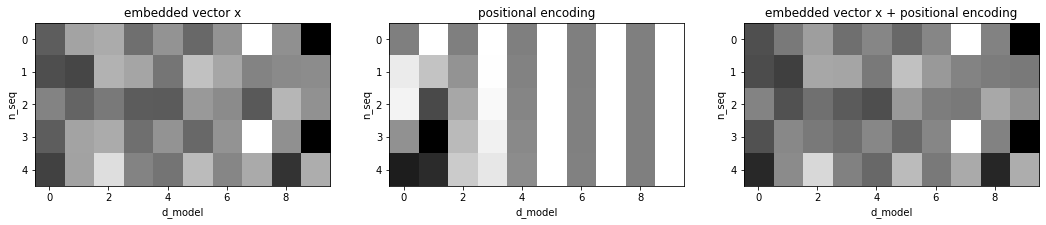

In [8]:
torch.random.manual_seed(15)

# 단어장 크기 11, 임베딩 벡터 길이 10인 임베딩 층 선언
V = 11
d_model = 10
emb = Embeddings(d_model, V)
# 길이 10인 문장의 위치를 인코딩하는 위치 인코딩 층 선언
pe  = PositionalEncoding(d_model, 0.1)
# 그림 그리기 위해 positional encoding을 복사해둠
pe_ = pe.pe.clone()

# 문장 길이는 5이고
n_seq = 5
# 0~10까지 숫자 5개를 무작위로 뽑아서 문장을 구성
# 이 예에서 문장은 실제 단어로 구성된 것은 아니고 0, 1, 2, 3, ..., 10인 
# 숫자를 단어로 간주함
x = torch.randint(0, V-1, (1, n_seq,), requires_grad=False)
print("integer tokens:", x)

# Feed forward Embeddings-PositionalEncoding
# 숫자(단어) 다섯개로 구성된 입력을 임베딩층을 통해 (n_seq, d_model)로 변환
embedded = emb(x)

# 임베딩 벡터에 대한 위치 인코딩 정보를 구해서 임베딩 벡터에 더함
embedded_pe = pe(embedded)

# 임베딩 벡터와 위치 인코딩이 더해진 입력 벡터를 그림 
fig, axs = plt.subplots(figsize=(18,3), nrows=1, ncols=3)
axs[0].imshow(embedded.detach().numpy()[0], aspect='auto', cmap='gray')
axs[0].set_xlabel('d_model')
axs[0].set_ylabel('n_seq')
axs[0].set_title(f"embedded vector x")

axs[1].imshow(pe_.numpy()[0][:x.shape[1]], aspect='auto', cmap='gray')
axs[1].set_xlabel('d_model')
axs[1].set_ylabel('n_seq')
axs[1].set_title(f"positional encoding")

axs[2].imshow(embedded_pe.detach().numpy()[0], aspect='auto', cmap='gray')
axs[2].set_xlabel('d_model')
axs[2].set_ylabel('n_seq')
axs[2].set_title(f"embedded vector x + positional encoding")

plt.show()


오른쪽 그림을 보면 위치 정보가 임베딩 벡터에 대해져서 원래 임베딩 벡터와는 색이 조금씩 달라진 것을 확인할 수 있습니다. 

## Encoder

이제 인코더로 데이터를 입력하기 위한 준비를 마쳤으니 인코더 구조를 알아봅시다. 글 시작 부분에 제시된 트랜스포머의 그림에서 Multi-Head Attention, Add & Norm 부분을 조금 더 자세히 그리면 아래와 같습니다.

![picture](https://drive.google.com/uc?id=10OW0QpQ5jTiW_K__FjmNZphB3fKuSacy)



임베딩과 포지션 인코딩이 끝난 입력이 Q, K, V라는 세 입력으로 인코더로 들어갑니다. 일반적으로 Q(쿼리), K(키), V(벨류)는 다른 값이 되어야 하지만 여기선 셀프 어텐션을 수행하기 때문에 같은 값으로 입력됩니다. 어텐션은 트랜스포머 이전까지 인코더와 디코더 간에 일어나는 연산으로 개발되었으며 셀프 어텐션에 대응되는 용어로 크로스 어텐션이라고 부르기도 합니다. 


### Attention


어텐션의 기본적인 동작 방식은 쿼리를 가지고 키로 질의를 해서 얻은 어텐션 가중치를 벨류에 적용하는 것입니다. 보통 어텐션에서 키란 인코더에서 생성한 정보로 이 정보를 디코더에게 효율적으로 전달하는 것이 어텐션의 주 목적입니다. 왜냐하면 디코더는 좋은 결과를 생성하기 위해 인코더의 정보를 가능한 많이 활용하는 편이 도움이 되기 때문입니다. 이전 seq2seq는 인코더가 인코딩한 마지막 결과만 디코더로 전달하기 때문에 디코더 입장에서는 좋은 결과를 생성하기 힘든 것이죠. 전체적인 과정은 대략 다음처럼 진행됩니다.

1. 인코더는 인코딩 중에 생성된 정보 다시말해 키를 모두 가지고 있습니다.
2. 디코더가 정보를 생성할 때 디코더가 만든 중간 결과 즉 쿼리를 가지고 이 쿼리와 가장 관계가 높은 정보가 어떤 것인지 인코더 쪽에 물어 봅니다. 
3. 인코더는 자기가 인코딩하면서 생성한 정보(키)들 중에 요청받은 쿼리와 어떤 키가 얼마나 적합한지 가중치 계산을 합니다.
4. 인코더는 이렇게 계산된 가중치를 디코더로 전달할 벨류라는 값에 가중합하여 디코더로 전달합니다.
5. 디코더는 4에서 전달받은 정보와 현재 디코더가 디코딩한 정보를 합하여 최종 결과를 만들어 냅니다.

이렇게 크로스 어텐션인 경우 대충 아이디어만 들어도 충분히 성능 향상에 영향을 미치겠다는 생각이 듭니다. 하지만 트랜스포머는 이 어텐션 아이디어를 인코더 또는 디코더에만 적용하는 식으로 적용범위를 넓혔습니다. 인코더는 입력 정보끼리 어텐션을 계산해서 디코더가 디코딩하기 좋은 인코딩 정보를 만들어 낼 수 있고 디코더도 마찬가지로 디코딩되는 정보 끼리 어텐션을 해서 더 좋은 결과를 만들어 낼수 있게 되는 것입니다. 이런 어텐션을 셀프 어텐션이라 합니다.

셀프 어텐션은 논문에서 제시하는 다음 수식으로 수행됩니다.

$$
\text{Attention}(Q, K, V) = \text{softmax} \left( \frac{QK^T}{\sqrt{d_k}} \right)V
$$






이렇게 셀프 어텐션이 되면 어떤 점이 좋아지는지 개념을 이해하기 위해 간단한 그림을 보도록 하겠습니다.


![picture](https://drive.google.com/uc?id=1c_TAUg5FY3YNknOMKZMW8XGGbwTNGlzF)

위 그림은 i love you so much라는 토큰들이 임베딩되는 상황을 나타냅니다. 우선 $W^Q_i$, $W^K_i$, $W^V_i$를 각각 곱하여 $Q$, $K$, $V$를 만들고 그렇게 만들어진 텐서는 색깔을 다르게 표현했습니다. 이후 $\text{softmax} \left( \frac{QK^T}{\sqrt{d_k}} \right)$가 실행되면 $(n_{\text{seq}}, n_{\text{seq}})$인 `p_attn` 행렬이 만들어지는데 이 행렬은 각 토큰들간의 관계가 계산되도록  $W^Q_i$, $W^K_i$가 학습되길 바라는 것입니다.  $W^Q_i$, $W^K_i$가 잘 학습되어 i love you so much라는 문장에서 각 토큰간의 관계가 잘 만들어졌다고 가정하겠습니다. 그러면 love라는 토큰은 한 문장안에서 love, you 라는 토큰하고 관계가 높게 표현될 수 있습니다. 그림에서  `p_attn`을 보면 love에 해당하는 행에서 love와 you에 해당하는 열이 붉게 빛나는 것을 볼 수 있습니다. 이렇게 인코딩된 어텐션 행렬과 $V$를 곱하게 됩니다. 행렬곱은 앞에서 곱하는 행렬의 행으로 뒤에서 곱하는 행렬의 행을 선형조합하는 것과 같습니다. 최종적으로 계산된 `head_i`에서 love에 해당하는 행은 $V$ 행렬의 행 다섯 개가 선형조합된 것인데 이때 $V$에서 love와 you에 해당하는 행에 높은 가중치가 부여되어 조합된 벡터가 됩니다. 

이렇게 셀프 어텐션되어 출력되는 결과는 각 토큰이 `d_model`사이즈로 변환된 벡터를 가지는데 그치지 않고 각 벡터들이 서로 관계가 높은 토큰들끼리 잘 조합되어 만들어진 벡터가 되게 됩니다.

아래 코드는 어텐션을 구현한 것입니다. 쿼리, 키, 벨류로 무엇을 입력는가에 따라 셀프 어텐션과 크로스 어텐션으로 나눌 수 있으므로 구현 코드는 두 경우 모두 동일합니다.


In [9]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    # 아래서 nbatches는 미니배치 크기, 코드에서 nbatches라는 변수명을 쓰므로
    # 표기를 통일하기 위해 nbatches로 표기
    # query: (nbatches, h, n_seq, d_k)
    # key:   (nbatches, h, n_seq, d_k)
    # value: (nbatches, h, n_seq, d_v) 인데 d_k=d_v로 두었음
    # 이 함수는 아래쪽 MultiHeadedAttention 클래스의 foward 함수에서 호출됨

    d_k = query.size(-1)
    
    # Scaled에 대한 여러 참고 링크들
    # https://stats.stackexchange.com/questions/318243/variance-and-expectation-of-dot-product
    # https://www.reddit.com/r/learnmath/comments/9gbk4q/mean_and_variance_of_dot_product_of_two_random/
    # https://stats.stackexchange.com/questions/52646/variance-of-product-of-multiple-random-variables
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    # scores: (nbatches, h, n_seq, n_seq)
    
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    p_attn = F.softmax(scores, dim = -1)

    if dropout is not None:
        p_attn = dropout(p_attn)

    # torch.matmul(p_attn, value): (nbatches, h, n_seq, n_seq)*(nbatches, h, n_seq, d_v)
    # = (nbatches, h, n_seq, d_v),      p_attn: (nbatches, h, n_seq, nseq)
    return torch.matmul(p_attn, value), p_attn

위 과정을 Scaled-dot product attention이라고 하는데 $\sqrt{d_k}$로 나누는 부분 때문에 scaled라는 이름이 붙었습니다. $\sqrt{d_k}$로 나누는 이유는 softmax를 취한 후 값들이 극단적으로 0과 1이 몰리게 되는 것을 막기 위함입니다. 만약 이런 현상이 일어난다면 softmax를 미분했을 때 미분 계수가 거의 0이 되어 그래디언트를 구하기 힘들어지는 문제가 생깁니다. 좀 더 자세한 설명은 아래 기술하였습니다. 

바쁘신 분들은 스킵해도 좋겠습니다. 🤨

인코더는 N개가 누적되면서 인코더의 출력이 다시 인코더의 입력으로 들어가는 구조로 되어 있습니다. 그림을 보면 인코더가 인코딩을 출력하기 전에 레이어 정규화층을 거치게 됩니다. 즉 셀프 어텐션을 위해 입력되는 $Q$, $K$는 레이어 정규화를 거치게 되므로 $Q$, $K$의 행벡터 $\mathbf{q}$와 $\mathbf{k}$의 요소들은 대략적으로 평균 0, 분산 1을 따른다고 가정할 수 있습니다.

$$
q_i , k_i \sim p(0, 1)
$$

행렬곱 $Q K^T$에서 $Q$의 길이 $d_k$인 행벡터 $\mathbf{q}$와 $K$의 열벡터 $\mathbf{k}$가 내적되는데 이 때 벡터의 요소가 서로 독립이고 위처럼 평균 0, 분산 1을 따른다고 가정하면 $\mathbf{q} \cdot \mathbf{k}$는 평균 0, 분산 $d_k$를 가지게 됩니다. 이는 다음처럼 보일 수 있습니다.

$$
\begin{aligned}
\mathbb{E}\left[\mathbf{q} \cdot \mathbf{k}\right] 
&= \mathbb{E}\left[ \sum_{i=1}^{d_k} q_i k_i \right] \\
&= \sum_{i=1}^{d_k} \mathbb{E} \left[ q_i k_i \right]
\end{aligned} \tag{1}
$$

위 식(1)에서 기댓값의 성질 $\mathbb{E}[X+Y] = \mathbb{E}[X]+\mathbb{E}[Y]$가 사용되었습니다. 이제 시그마 안쪽 $\mathbb{E} \left[ q_i k_i \right]$를 전개해보면

$$
\begin{aligned}
\mathbb{E}[q_i k_i] 
&= \sum_{q_i} \sum_{k_i} q_i  k_i \ p(q_i, k_i) \\
&= \sum_{q_i} \sum_{k_i} q_i  k_i \ p(q_i) p(k_i)  \quad \because q_i \text{ and } k_i \text{ are independent}  \\
&= \sum_{q_i} q_i \, p(q_i) \sum_{k_i} k_i \, p(k_i) \\
&= \mathbb{E}[q_i] \, \mathbb{E}[k_i] = 0 \quad \because \mathbb{E}[q_i] = \mathbb{E}[k_i] = 0
\end{aligned} \tag{2}
$$

식(2)의 결과를 식(1)에 대입하면 

$$
\begin{aligned}
\mathbb{E}\left[\mathbf{q} \cdot \mathbf{k}\right] 
&= \mathbb{E}\left[ \sum_{i=1}^{d_k} q_i k_i \right] \\
&= \sum_{i=1}^{d_k} \mathbb{E} \left[ q_i k_i \right] \\
&= \sum_{i=1}^{d_k} 0 = 0
\end{aligned}
$$

이 되게 됩니다.

분산도 위와 비슷한 과정으로 $d_k$가 됨을 보일 수 있습니다.

$$
\begin{aligned}
\text{Var}\left[\mathbf{q} \cdot \mathbf{k}\right] 
&= \text{Var}\left[\sum_{i=1}^{d_k} q_i k_i \right]  \\
&= \sum_{i=1}^{d_k} \text{Var} \left[ q_i k_i \right]
\end{aligned} \tag{3}
$$

식(3)에서 독립인 확률변수에 대한 분산의 성질 $\text{Var}[X+Y] = \text{Var}[X] + \text{Var}[Y]$가 사용되었습니다. 

이제 기댓값처럼 시그마 안쪽을 전개하면

$$
\begin{aligned}
\text{Var}\left[ q_i k_i\right] 
&= \mathbb{E}[q_i^2 k_i^2]-\left(\mathbb{E}[q_i k_i ]\right)^2 \\[5pt]
&= \mathbb{E}\left[q_i^2\right] \mathbb{E}\left[ k_i^2 \right] - \mathbb{E}\left[q_i\right]^2 \mathbb{E} [k_i]^2 \\[5pt]
&=\left( \text{Var}[q_i]+\mathbb{E}[q_i]^2 \right) \left( \text{Var}[k_i]+\mathbb{E}[k_i]^2 \right) - \mathbb{E}\left[q_i\right]^2 \mathbb{E} [k_i]^2 \\[5pt]
&= \text{Var}[q_i] \text{Var}[k_i] + \text{Var}[q_i] \mathbb{E} [k_i]^2 + \mathbb{E} [q_i]^2 \text{Var}[k_i] + \mathbb{E}\left[q_i\right]^2 \mathbb{E} [k_i]^2 - \mathbb{E}\left[q_i\right]^2 \mathbb{E} [k_i]^2 \\[5pt]
&= \text{Var}[q_i] \text{Var}[k_i] + \text{Var}[q_i] \mathbb{E} [k_i]^2 + \mathbb{E} [q_i]^2 \text{Var}[k_i]
\end{aligned}
$$

여기서 각 요소들은 $ \mathbb{E} [q_i] = \mathbb{E} [k_i] = 0 $ , $\text{Var}[q_i] = \text{Var}[k_i] = 1$이므로

$$
\text{Var}\left[ q_i k_i\right] = \text{Var}[q_i] \text{Var}[k_i] = 1 \tag{4}
$$

이 되고 식(4)를 윗 식에 대입하면

$$
\begin{aligned}
\text{Var}\left[\mathbf{q} \cdot \mathbf{k}\right] 
&= \text{Var}\left[\sum_{i=1}^{d_k} q_i k_i \right]  \\
&= \sum_{i=1}^{d_k} \text{Var} \left[ q_i k_i \right] \\
&= \sum_{i=1}^{d_k}  \text{Var}[q_i] \text{Var}[k_i] \\
&= \sum_{i=1}^{d_k} 1 = d_k
\end{aligned}
$$

이 됨을 알 수 있습니다.


두 행렬을 곱한 행렬의 요소 $\left(Q K^T \right)_{ij}$는 $\mathbf{q}_i \cdot \mathbf{k}_j$로 계산되는데 앞선 계산에서 본것 처럼 분산이 $d_k$가 되므로 $d_k$가 커질 수록 $\left(Q K^T \right)_{ij}$의 값들의 차이도 커지게 됩니다. $\left(Q K^T \right)_{ij}$들의 분산이 커지면 $ Q K^T  $가 소프트맥스 함수를 거친 후 요소의 값은 1에 아주 가깝거나 0에 아주 가까운 값들로 구성되게 될 것입니다. 한편 소프트맥스 $\mathbf{s}(\mathbf{z})$의 미분은 다음과 같습니다.

$$
\frac{\partial}{\partial z_j} s_i(\mathbf{z})=\begin{cases}
s_j(\mathbf{z}) (1-s_j(\mathbf{z})), & \mbox{if } i = j \\
-s_i(\mathbf{z})s_j(\mathbf{z}), & \mbox{if } i \neq j
\end{cases}
$$

위 식을 보면 소프트맥스 함수의 미분계수는 결국 소프트맥스 함수의 요소들 끼리 곱으로 결정되는데 이 요소들이 0에 아주 가깝거나 1에 아주 가깝게 되면 미분계수가 매우 작아지는 문제가 생기게 됩니다. 결과적으로 소프트맥스 함수를 백워드 패스할 때 미분계수가 매우 작아져서 학습에 문제가 생기게 되겠죠. 그래서 앞서 구한 $\left(Q K^T \right)_{ij}$의 표준편차인 $\sqrt{d_{\text{k}}}$로 나눠서 평균과 분산을 0, 1에 가깝게 만들려하는 것입니다. 

#### Multi-Head Attention

앞 절에서 이야기한 어텐션을 한번만 하는 것이 아니라 $h$번하고 그 결과로 나온 $(n_{seq}, d_{v})$인 결과 $h$개를 $d_v$ 방향으로 `concat`시켜 최종적으로 $(n_{seq}, hd_{v})$ 만들게 됩니다. 위 인코더 그림에서 이를 표현하고 있습니다. 

그리고 이 $(n_{seq}, hd_{v})$를 $(hd_{v}, d_{model})$인 $W^o$와 곱하여 결과를 $(n_{seq}, d_{model})$로 만들게 됩니다. 아래 그 코드가 있는데 매우 교묘하게 코딩되어 있어 주의깊게 볼 필요가 있습니다. 우선 코드에 적혀있는 주석을 읽고 코드를 이해해봅시다.


In [10]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [11]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h  # Q, K의 차원
        self.h = h
        
        # Wq, Wk, Wv and Wo
        # Wq, Wk, Wv를 각각 h개 만들지 않고 
        # Wq, Wk, Wv를 d_model의 1/h 크기로 만듬
        self.linears = clones(nn.Linear(d_model, d_model), 4) 
        
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        # query, key, value: (n_seq, d_model)
        "Implements Figure 2"
        if mask is not None:
            # EncoderLayer에서 호출될 때
            # mask는 src_mask: (nbatches, 1, n_seq_src)
            # DecoderLayer에서 호출될 때
            # self_attn으로 호출되면 mask는 tgt_mask: (nbatches, n_seq_trg, n_seq_trg)
            # src_attn(cross_attn)으로 호출되며 mask는 src_mask: (nbatches, 1, n_seq_src)
            
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        # self.linears는 요소 네갠데 (query, key, value)와 짝을 맞춰서
        # 루프는 총 3번 돌아감
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        # 이 라인이 실행되면 query, key, value는 각각
        # (nbatches, h, n_seq, d_k) 가 됨
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        # x: (nbatches, h, n_seq, d_v),  self.attn: (nbatches, h, n_seq, n_seq)

        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        # x: (nbatches, n_seq, h*d_k) 여기서 h*d_k=d_model

        # 4) matmul x and Wo -> (nbatches, n_seq, d_model)
        return self.linears[-1](x)

위 코드에서 가장 난해한 코드는 주석 1) 부분입니다. 

```python
# 1) Do all the linear projections in batch from d_model => h x d_k 
# self.linears는 요소 네갠데 (query, key, value)와 짝을 맞춰서
# 루프는 총 3번 돌아감
query, key, value = \
    [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        for l, x in zip(self.linears, (query, key, value))]
# 이 라인이 실행되면 query, key, value는 각각
# (nbatches, h, n_seq, d_k) 가 됨
```

1)에서 $(n_{seq}, d_{k})$ 모양의 쿼리, 키, 벨류 $h$개를 동시에 만들고 있습니다. 쿼리를 만드는 과정을 아래 그림으로 자세히 나타냈습니다. 나머지 키와 벨류에 대해서도 동일한 연산이 수행됩니다.
  
![picture](https://drive.google.com/uc?id=10JMUOLLUgyPJwqQvVyWG2J9MmUIB_gEo)

그림 상단에 코드가 주석 1)에 해당하는 코드이며 코드 부분이 진행되는 순서대로 텐서를 표현하였습니다. 1)에서 결과를 앞서 알아본 `attention` 함수로 입력하여 어텐션 결과와 어텐션 맵을 돌려 받는 부분이 2)입니다. 그런 다음 3)에서 $h$개 어텐션 결과를 `concat`하고 이를 4)에서 $W^O$와 곱하게 됩니다.

마지막 완전연결층의 가중치 $W^{O}$는 $(hd_v , d_{\text{model}})$ 크기를 가지므로 이 층의 입력차원은 $hd_v$, 출력차원은 $d_{\text{model}}$이 됩니다. 입력으로 들어오는 멀티 헤드 어텐션의 출력은 $(n_{\text{seq}} , hd_k)$입니다. 셀프 어텐션에서 $d_k=d_v$이므로 마지막 완전연결층을 통과하면 출력은 $(n_{\text{seq}},d_{\text{model}})$이 됩니다. 

위 멀티헤드어텐션 `forward()`에서 마지막 줄입니다.

```python
# matmul x and Wo -> (nbatches, n_seq, d_model)
return self.linears[-1](x)
```

3)과 4) 과정을 아래 그림으로 나타내었습니다. 인코더의 전체 그림과 함께 비교하면 이해하기가 훨씬 쉬워집니다.

![picture](https://drive.google.com/uc?id=10KXLvpL_UU1NbWQT5sTlaiF5EHtQdhek)


### Normalization

앞선 단계를 거쳐 얻은 결과는 모양이 $(\text{nbatches}, n_{\text{seq}}, d_{\text{model}})$이고 인코더의 입력도 모양이 $(\text{nbatches}, n_{\text{seq}}, d_{\text{model}})$이므로 서로 요소끼리 더할 수 있습니다. 이렇게 더하는 과정을 스킵커넥션skip-connection이라고 합니다. 스킵 커넥션은 ResNet[[6](https://arxiv.org/abs/1512.03385)]에서 소개된 기법으로 이 후 모델에서는 거의 필수로 사용되는 기법입니다. 이렇게 스킵커넥션까지 거친 텐서를 정규화하게 되는데 여기서는 보편적으로 사용하는 배치정규화를 쓰지 않고 레이어 정규화를 사용합니다. 

배치 정규화와 레이어 정규화의 차이를 알아보기 위해 구체적인 예를 들어 보겠습니다.

#### Batch Normalization

배치 정규화에 대한 수식은 아래와 같습니다.

$$
y = \frac{x - \mathbb{E}[x]}{\sqrt{\text{Var}[x]+\epsilon}} * \gamma + \beta
$$

식만보면 입력 배치 $x$에 대한 평균과 분산을 구해서 입력들에 대해서 표준화 작업을 하는 것입니다. 그런데 PyTorch 구현체를 보면 상황이 조금 더 복잡합니다.


![picture](https://drive.google.com/uc?id=1BdMW-mYOwNea6yH6wyk63ZPCBSsHLGij)

위 그림은 데이터 하나가 요소 4개짜리 벡터이고 미니배치 크기가 3인 상황을 나타내었습니다. 이 경우 입력 텐서는 (3,4) 또는 (3,1,4)입니다. 트랜스포머로 입력되는 상황을 고려하면 (3,1,4)가 적합한데 각 차원은 (nbatches, n_seq, embedding)으로 샘플은 세 개, 각 샘플당 토큰은 한 개, 각 토큰은 숫자 네 개로 임베딩되어 있는 상황입니다. 노란색, 주황색, 보라색 데이터가 각각 네트워크에 입력되고 길이 여섯개짜리 벡터로 변환되면 출력은 (3,1,6)이 됩니다.   

이 출력에 배치 정규화를 적용하면 `(N, C, L)`에서 `C`에 대해 데이터를 구분해서 `C`별로 평균과 분산을 구하게 됩니다. 이것은 이미지에 대해서 배치 정규화를 적용하면 이미지의 채널별로 평균과 분산을 구하는 것과 동일한 방식입니다.

실제로 그렇게 작동하는지 아래 pytorch 코드와 직접 만든 배치 정규화 코드의 결과를 비교하였습니다. 



In [12]:
torch.manual_seed(0)

# 배치사이즈 3, 단어 한개로 구성된 문장, feature 4
x = torch.randn(3, 1, 4)
print('\nINPUT', x.shape)
print(x)

# 4차원 벡터를 6차원 벡터로 변환하는 완전연결 층
linear = nn.Linear(x.shape[-1], 6)
x = linear(x)
print('\nACTIVATION', x.shape)
print(x)

#===================
# batch norm.
# pytorch 
bnorm = nn.BatchNorm1d(x.shape[1], eps=0., momentum=0.)
print('\nPYTORCH BATCH NORM. 1D')
print(bnorm(x))

# 직접 만들기
mean = x.mean(axis=(0,2)).reshape(-1,1)
var = x.var(axis=(0,2), unbiased=False).reshape(-1,1)
gamma = torch.ones(x.shape)
beta = torch.zeros(x.shape)
print('\nMY BATCH NORM.')
print('mean shape:', mean.shape)
print('var shape:', var.shape)
print(((x - mean) / torch.sqrt(var))*gamma + beta)
#===================




INPUT torch.Size([3, 1, 4])
tensor([[[ 1.5410, -0.2934, -2.1788,  0.5684]],

        [[-1.0845, -1.3986,  0.4033,  0.8380]],

        [[-0.7193, -0.4033, -0.5966,  0.1820]]])

ACTIVATION torch.Size([3, 1, 6])
tensor([[[-1.6115,  0.2043,  0.3828, -0.4272, -0.1355, -0.9343]],

        [[-0.4144,  0.7838,  0.4598,  0.5056,  0.1713,  1.1928]],

        [[-0.5397,  0.4543,  0.7689,  0.4446,  0.1475,  0.2965]]],
       grad_fn=<AddBackward0>)

PYTORCH BATCH NORM. 1D
tensor([[[-2.5974,  0.1627,  0.4341, -0.7971, -0.3537, -1.5679]],

        [[-0.7777,  1.0436,  0.5512,  0.6207,  0.1127,  1.6653]],

        [[-0.9681,  0.5429,  1.0210,  0.5281,  0.0764,  0.3030]]],
       grad_fn=<NativeBatchNormBackward0>)

MY BATCH NORM.
mean shape: torch.Size([1, 1])
var shape: torch.Size([1, 1])
tensor([[[-2.5974,  0.1627,  0.4341, -0.7971, -0.3537, -1.5679]],

        [[-0.7777,  1.0436,  0.5512,  0.6207,  0.1127,  1.6653]],

        [[-0.9681,  0.5429,  1.0210,  0.5281,  0.0764,  0.3030]]],
       grad_

두 경우 모두 출력이 동일하고 평균과 분산은 숫자 하나라는 사실을 알 수 있습니다. (이 예에서 C=1이기 때문입니다.)

![picture](https://drive.google.com/uc?id=1RBZJ6wWqq5PABCW8Yw5-Ny9yupcxNRqA)

이번에는 데이터가 위처럼 입력된다고 생각해봅시다. 이 상황은 샘플 세 개가 입력되는데 전과는 다르게 각 데이터는 토큰이 두 개로 구성된 문장이고 토큰 하나는 숫자 네 개짜리 벡터로 표현된 상황입니다. 이번 예에서는 C=2이기 때문에 각 샘플의 첫번째 단어끼리 평균과 분산을 구하고, 두번째 단어끼리 평균과 분산을 구해서 각 단어에 대해 표준화를 수행할 것입니다.

아래 코드를 보면 그 사실을 확인할 수 있습니다.


In [13]:
# 배치사이즈 3, 단어 두 개로 구성된 문장, feature 4
x = torch.randn(3, 2, 4)
print('\nINPUT', x.shape)
print(x)

# 4차원 벡터를 6차원 벡터로 변환하는 완전연결 층
linear = nn.Linear(x.shape[-1], 6)
x = linear(x)
print('\nACTIVATION', x.shape)
print(x)

#===================
# batch norm.
# pytorch 
bnorm = nn.BatchNorm1d(x.shape[1], eps=0., momentum=0.)
print('\nPYTORCH BATCH NORM. 1D')
print(bnorm(x))

# 직접 만들기
mean = x.mean(axis=(0,2)).reshape(-1,1)
var = x.var(axis=(0,2), unbiased=False).reshape(-1,1)
gamma = torch.ones(x.shape)
beta = torch.zeros(x.shape)
print('\nMY BATCH NORM.')
print('mean shape:', mean.shape)
print('var shape:', var.shape)
print(((x - mean) / torch.sqrt(var))*gamma + beta)
#===================


INPUT torch.Size([3, 2, 4])
tensor([[[ 5.4329e-01, -3.9516e-01,  2.0553e-01, -4.5033e-01],
         [-5.7308e-01, -5.5536e-01,  5.9432e-01,  1.5419e+00]],

        [[-1.0925e+00, -8.5194e-02, -9.3348e-02,  6.8705e-01],
         [-8.3832e-01,  8.9182e-04,  8.4189e-01, -4.0003e-01]],

        [[ 6.2114e-01,  6.3818e-01, -2.4600e-01,  2.3025e+00],
         [-1.8817e+00, -4.9727e-02, -1.0450e+00, -9.5650e-01]]])

ACTIVATION torch.Size([3, 2, 6])
tensor([[[-0.0636, -0.0346,  0.0337, -0.0617, -0.7393,  0.5536],
         [ 0.8464,  1.3011,  0.0941,  0.5593,  0.2273,  0.2352]],

        [[ 0.6898,  0.7568,  0.4834,  0.5283,  0.2946, -0.0747],
         [ 0.6558,  0.7065, -0.0185,  0.2920, -0.5097, -0.1648]],

        [[-0.2619,  0.3526,  0.0770, -0.2704,  0.9377,  0.2629],
         [ 0.6593,  0.0531,  1.1190,  0.7146,  0.0106, -0.2787]]],
       grad_fn=<AddBackward0>)

PYTORCH BATCH NORM. 1D
tensor([[[-0.6198, -0.5497, -0.3845, -0.6153, -2.2559,  0.8745],
         [ 1.0204,  1.9767, -0.5619, 

직접 구현한 코드를 보면 평균과 분산이 숫자 두개로 구성된 것을 알 수 있습니다. 이 두 경우 모두 구해진 평균과 분산에서 미니배치의 차원인 3이 사라진 것을 확인할 수 있습니다. 미니배치 내 샘플들끼리 평균과 분산을 구했기 때문입니다.

만약 첫번째 예와 같은 상황에서 입력을 (3,4)로 했다면 평균과 분산을 구하는 방식이 조금 달라지게 됩니다.

![picture](https://drive.google.com/uc?id=1hRLd1iV5wlLDF__VD4HtozaKnNgdgQYv)

길이 6짜리 벡터를 더해서 평균벡터와 분산벡터를 구하는 상황입니다. 이런 식으로 동작하기 위해서 `(N,L)`에서 `L`을 `BatchNorm1d()`에 넘기면 됩니다. 아래 실험 코드가 있습니다. 이런 경우를 pytorch 문서에서는 'Temporal Batch Normalization'이라고 부릅니다. 미니배치에 있는 샘플들을 대상으로 `C`차원에 대해서 각각 구분해서 평균과 분산을 구해야 하는데 샘플에 `C`차원이 없어서 이렇게 이름 붙인것 같습니다.

In [14]:
# 배치사이즈 3, 단어 한개로 구성된 문장, feature 4, 여기선 C가 없음
x = torch.randn(3, 4)
print('\nINPUT', x.shape)
print(x)

# 4차원 벡터를 6차원 벡터로 변환하는 완전연결 층
linear = nn.Linear(x.shape[-1], 6)
x = linear(x)
print('\nACTIVATION', x.shape)
print(x)


# pytorch 
bnorm = nn.BatchNorm1d(x.shape[1], eps=0., momentum=0.)
print('\nPYTORCH BATCH NORM. 1D')
print(bnorm(x))

# 직접 만들기
mean = x.mean(axis=0)
var = x.var(axis=0, unbiased=False)
gamma = torch.ones(x.shape)
beta = torch.zeros(x.shape)
print('\nMY BATCH NORM.')
print('mean shape:', mean.shape)
print('var shape:', var.shape)
print(((x - mean) / torch.sqrt(var))*gamma + beta)




INPUT torch.Size([3, 4])
tensor([[ 1.8929,  3.1110, -0.4584, -0.3360],
        [-1.5700,  1.2315,  1.3946,  1.1711],
        [ 0.4335, -1.7343, -1.3360,  0.8871]])

ACTIVATION torch.Size([3, 6])
tensor([[-0.8547,  0.8803, -0.9615,  0.1794, -0.1448, -1.3131],
        [-0.7770,  0.4903, -1.8076, -0.7847, -0.0231,  0.8162],
        [ 1.2591, -1.1274,  0.3239,  0.6613,  0.3677, -1.1282]],
       grad_fn=<AddmmBackward0>)

PYTORCH BATCH NORM. 1D
tensor([[-0.7464,  0.9195, -0.1671,  0.2673, -0.9670, -0.8009],
        [-0.6670,  0.4708, -1.1326, -1.3363, -0.4102,  1.4099],
        [ 1.4135, -1.3903,  1.2997,  1.0690,  1.3772, -0.6089]],
       grad_fn=<NativeBatchNormBackward0>)

MY BATCH NORM.
mean shape: torch.Size([6])
var shape: torch.Size([6])
tensor([[-0.7464,  0.9195, -0.1671,  0.2673, -0.9670, -0.8009],
        [-0.6670,  0.4708, -1.1326, -1.3363, -0.4102,  1.4099],
        [ 1.4135, -1.3903,  1.2997,  1.0690,  1.3772, -0.6089]],
       grad_fn=<AddBackward0>)


출력 샘플 하나가 길이 6짜리 벡터이므로 이런식으로 동작하는것이 좀 더 일반적인 경우라 할 수 있습니다. 버클리 대학교 인공지능 수업 [[cs182](https://cs182sp21.github.io/)]에서도 배치 정규화를 정확히 이렇게 설명하고 있습니다. 아래는 설명을 발췌한 슬라이드인데 수식을 보면 그냥 미니배치 안의 샘플들끼리 평균을 구하고 표준편차를 구하는 것을 확인할 수 있습니다.



![picture](https://drive.google.com/uc?id=1YYnMN9hD6xJY5zNFvEG1nBslg4caMsVm)


이제 배치놈에 대해서 자세히 알아봤으니 레이어 정규화에 대해서 알아볼 차례입니다.




#### Layer Normalization

레이어 정규화는 배치 정규화보다 개념이 간단합니다. 그냥 출력층 모양에 맞춰서 평균과 분산을 구하면 됩니다.

![picture](https://drive.google.com/uc?id=1jBGGDQPHCWppGLMuY0Nw0J48AYQ6SEHe)

위 그림이라면 출력층이 숫자 여섯개인 벡터이므로 출력도 여섯개씩 묶어서 평균과 분산을 구하면 됩니다. 아래 코드에 실험결과가 있습니다.



In [15]:
torch.manual_seed(0)

# 배치사이즈 3, 단어 한개로 구성된 문장, feature 4
x = torch.randn(3, 1, 4)
print('\nINPUT', x.shape)
print(x)

# 4차원 벡터를 6차원 벡터로 변환하는 완전연결 층
linear = nn.Linear(x.shape[-1], 6)
x = linear(x)
print('\nACTIVATION', x.shape)
print(x)

#===================
# layer norm.
# pytorch 
# 정규화할 shape을 출력레이어 모양에 맞게 설정한다.
lnorm = nn.LayerNorm(x.shape[2], eps=0.)
print('\nPYTORCH LAYER NORM.')
print(lnorm(x))

# 직접 만들기
mean = x.mean(axis=-1).reshape(-1,1,1)
var = x.var(axis=-1, unbiased=False).reshape(-1,1,1)
gamma = torch.ones(x.shape)
beta = torch.zeros(x.shape)
print('\nMY LAYER NORM.')
print('mean shape:', mean.shape)
print('var shape:', var.shape)
print(((x - mean) / torch.sqrt(var))*gamma + beta)
#===================




INPUT torch.Size([3, 1, 4])
tensor([[[ 1.5410, -0.2934, -2.1788,  0.5684]],

        [[-1.0845, -1.3986,  0.4033,  0.8380]],

        [[-0.7193, -0.4033, -0.5966,  0.1820]]])

ACTIVATION torch.Size([3, 1, 6])
tensor([[[-1.6115,  0.2043,  0.3828, -0.4272, -0.1355, -0.9343]],

        [[-0.4144,  0.7838,  0.4598,  0.5056,  0.1713,  1.1928]],

        [[-0.5397,  0.4543,  0.7689,  0.4446,  0.1475,  0.2965]]],
       grad_fn=<AddBackward0>)

PYTORCH LAYER NORM.
tensor([[[-1.7441,  0.9143,  1.1757, -0.0102,  0.4169, -0.7525]],

        [[-1.7336,  0.6699,  0.0201,  0.1118, -0.5586,  1.4903]],

        [[-1.9794,  0.4748,  1.2514,  0.4509, -0.2829,  0.0851]]],
       grad_fn=<NativeLayerNormBackward0>)

MY LAYER NORM.
mean shape: torch.Size([3, 1, 1])
var shape: torch.Size([3, 1, 1])
tensor([[[-1.7441,  0.9143,  1.1757, -0.0102,  0.4169, -0.7525]],

        [[-1.7336,  0.6699,  0.0201,  0.1118, -0.5586,  1.4903]],

        [[-1.9794,  0.4748,  1.2514,  0.4509, -0.2829,  0.0851]]],
       gr

그림처럼 출력을 층 모양에 맞게 묶어서 평균과 분산을 구하면 숫자가 세 개 구해지게 됩니다. 위 코드의 출력에서 마지막에 구한 `mean`, `var`의 `shape`을 확인해보면 숫자 세 개로 구성된 것을 알 수 있습니다. 적절한 자리에 빼고, 나누고 하기 위해 `reshape`을 적당히 해주면 pytorch 결과와 똑같은 결과를 만들 수 있습니다.

레이어 정규화를 두번째 예에 적용해보면 다음처럼 각 토큰별로 계산하게 됩니다.

![picture](https://drive.google.com/uc?id=1TXKgQMek9cq4a0-fS_krZ1U3lTIZO7mO)

In [16]:
# 배치사이즈 3, 단어 두 개로 구성된 문장, feature 4
x = torch.randn(3, 2, 4)
print('\nINPUT', x.shape)
print(x)

# 4차원 벡터를 6차원 벡터로 변환하는 완전연결 층
linear = nn.Linear(x.shape[-1], 6)
x = linear(x)
print('\nACTIVATION', x.shape)
print(x)

# pytorch 
lnorm = nn.LayerNorm(x.shape[2], eps=0.)
print('\npytorch layer norm.')
print(lnorm(x))

# 직접 만들기
mean = x.mean(axis=-1).unsqueeze(-1)
var = x.var(axis=-1, unbiased=False).unsqueeze(-1)
gamma = torch.ones(x.shape)
beta = torch.zeros(x.shape)
print('\nmy layer norm.')
print('mean shape:', mean.shape)
print('var shape:', var.shape)
print(((x - mean) / torch.sqrt(var))*gamma + beta)


INPUT torch.Size([3, 2, 4])
tensor([[[ 5.4329e-01, -3.9516e-01,  2.0553e-01, -4.5033e-01],
         [-5.7308e-01, -5.5536e-01,  5.9432e-01,  1.5419e+00]],

        [[-1.0925e+00, -8.5194e-02, -9.3348e-02,  6.8705e-01],
         [-8.3832e-01,  8.9182e-04,  8.4189e-01, -4.0003e-01]],

        [[ 6.2114e-01,  6.3818e-01, -2.4600e-01,  2.3025e+00],
         [-1.8817e+00, -4.9727e-02, -1.0450e+00, -9.5650e-01]]])

ACTIVATION torch.Size([3, 2, 6])
tensor([[[-0.0636, -0.0346,  0.0337, -0.0617, -0.7393,  0.5536],
         [ 0.8464,  1.3011,  0.0941,  0.5593,  0.2273,  0.2352]],

        [[ 0.6898,  0.7568,  0.4834,  0.5283,  0.2946, -0.0747],
         [ 0.6558,  0.7065, -0.0185,  0.2920, -0.5097, -0.1648]],

        [[-0.2619,  0.3526,  0.0770, -0.2704,  0.9377,  0.2629],
         [ 0.6593,  0.0531,  1.1190,  0.7146,  0.0106, -0.2787]]],
       grad_fn=<AddBackward0>)

pytorch layer norm.
tensor([[[-0.0308,  0.0462,  0.2279, -0.0258, -1.8293,  1.6118],
         [ 0.7188,  1.7990, -1.0687,  0.

NLP에서는 시퀀스의 길이가 샘플마다 모두 달라서 패딩을 하게 되고 또 시퀀스 길이가 대체로 길어서 미니배치 사이즈를 크게 가져가지 못하기 때문에 배치 정규화를 사용하기 부적합하다고 판단하고 레이어 정규화를 사용했습니다.

In [17]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)

        # torch.nn.LayerNorm()과 맞추기 위해 unbiased=False로 수정
        std = x.std(-1, unbiased=False, keepdim=True)
        # std = x.std(-1, keepdim=True)
        
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    

위에서 만든 레이어 정규화 층을 테스트 해봅시다.

In [18]:
torch.manual_seed(0)

# 배치사이즈 3, 단어 한개로 구성된 문장, feature 4
x = torch.randn(3, 1, 4)
print('\nINPUT')
print(x)

# 4차원 벡터를 6차원 벡터로 변환하는 완전연결 층
linear = nn.Linear(x.shape[-1], 6)
x = linear(x)
print('\nACTIVATION')
print(x.shape)

#===================
# layer norm.
# pytorch 
lnorm2 = nn.LayerNorm(x.shape[-1], eps=0.)
print('\nPYTORCH LAYER NORM.')
print(lnorm2(x))

# 직접 만들기
mean = x.mean(axis=-1).reshape(-1,1,1)
var = x.var(axis=-1, unbiased=False).reshape(-1,1,1)
gamma = torch.ones(x.shape)
beta = torch.zeros(x.shape)
print('\nMY LAYER NORM.')
print('mean shape:', mean.shape)
print('var shape:', var.shape)
print(((x - mean) / torch.sqrt(var))*gamma + beta)

# 레이어 층
lnorm = LayerNorm(x.shape[-1], eps=0.)
print('\nclass LayerNorm')
print(lnorm(x))


#===================




INPUT
tensor([[[ 1.5410, -0.2934, -2.1788,  0.5684]],

        [[-1.0845, -1.3986,  0.4033,  0.8380]],

        [[-0.7193, -0.4033, -0.5966,  0.1820]]])

ACTIVATION
torch.Size([3, 1, 6])

PYTORCH LAYER NORM.
tensor([[[-1.7441,  0.9143,  1.1757, -0.0102,  0.4169, -0.7525]],

        [[-1.7336,  0.6699,  0.0201,  0.1118, -0.5586,  1.4903]],

        [[-1.9794,  0.4748,  1.2514,  0.4509, -0.2829,  0.0851]]],
       grad_fn=<NativeLayerNormBackward0>)

MY LAYER NORM.
mean shape: torch.Size([3, 1, 1])
var shape: torch.Size([3, 1, 1])
tensor([[[-1.7441,  0.9143,  1.1757, -0.0102,  0.4169, -0.7525]],

        [[-1.7336,  0.6699,  0.0201,  0.1118, -0.5586,  1.4903]],

        [[-1.9794,  0.4748,  1.2514,  0.4509, -0.2829,  0.0851]]],
       grad_fn=<AddBackward0>)

class LayerNorm
tensor([[[-1.7441,  0.9143,  1.1757, -0.0102,  0.4169, -0.7525]],

        [[-1.7336,  0.6699,  0.0201,  0.1118, -0.5586,  1.4903]],

        [[-1.9794,  0.4748,  1.2514,  0.4509, -0.2829,  0.0851]]],
       grad_fn

pytorch의 `nn.LayerNorm()`과 앞서 직접 만들어본 레이어 정규화 결과와 클래스로 제공된 코드의 결과가 동일한 것을 알 수 있습니다.


#### Instance Normalization

참고 삼아 인스턴스 정규화에 대한 실험 코드도 아래 제시 했습니다. 인스턴스 정규화는 배치 차원과 채널 차원을 제외한 차원에 대해서 평균을 내는 방식입니다. 지금까지 사용한 예를 들어 알아보면 데이터가 (3,2,4)일 때 인스턴스 정규화를 적용하면 (3,2,$\cdot$)차원에 대해서는 계산하지 않고 마지막 ($\cdot$, $\cdot$,4)차원인 네 개 숫자를 모두 더해서 4로 나눈 것이 평균이 됩니다. 그래서 평균과 분산은 (3,2,1)이 되고 이를 각 샘플과 채널에 대해서 정규화 하는 방식입니다.

In [20]:
# 배치사이즈 3, 단어 두 개로 구성된 문장, feature 4
x = torch.randn(3, 2, 4)
print('\nINPUT', x.shape)
print(x)

# 4차원 벡터를 6차원 벡터로 변환하는 완전연결 층
linear = nn.Linear(x.shape[-1], 6)
x = linear(x)
print('\nACTIVATION', x.shape)
print(x)

#===================
# batch norm.
# pytorch 
bnorm = nn.BatchNorm1d(x.shape[1], eps=0., momentum=0.)
print('\nPYTORCH BATCH NORM. 1D')
print(bnorm(x))
# 직접 만들기
mean = x.mean(axis=(0,2)).reshape(-1,1)
var = x.var(axis=(0,2), unbiased=False).reshape(-1,1)
gamma = torch.ones(x.shape)
beta = torch.zeros(x.shape)
print('\nMY BATCH NORM.')
print('mean shape:', mean.shape)
print('var shape:', var.shape)
print(((x - mean) / torch.sqrt(var))*gamma + beta)
#===================

#===================
# instance norm.
# pytorch 
inorm = nn.InstanceNorm1d(x.shape[1], eps=0., momentum=0.)
print('\nPYTORCH INSTANCE NORM. 1D')
print(inorm(x))
# 직접 만들기
mean = x.mean(axis=2).unsqueeze(2)#.reshape(-1,1)
var = x.var(axis=2, unbiased=False).unsqueeze(2)#.reshape(-1,1)
gamma = torch.ones(x.shape)
beta = torch.zeros(x.shape)
print('\nMY INSTANCE NORM.')
print('mean shape:', mean.shape)
print('var shape:', var.shape)
print(((x - mean) / torch.sqrt(var))*gamma + beta)


INPUT torch.Size([3, 2, 4])
tensor([[[ 0.0930, -0.6661,  0.6080, -0.7300],
         [-0.8834, -0.4189, -0.8048,  0.5656]],

        [[ 0.2886,  0.3866, -0.2011, -0.1179],
         [-0.8294, -1.4073,  1.6268,  0.1723]],

        [[-0.7043,  0.3147,  0.1574,  0.3854],
         [ 0.5737,  0.9979,  0.5436,  0.0788]]])

ACTIVATION torch.Size([3, 2, 6])
tensor([[[-0.6992,  0.6678, -0.1870,  1.0235, -0.1628, -0.0693],
         [-0.0563,  0.2134,  0.4644, -0.0637, -0.5647, -0.2266]],

        [[-0.4087,  0.0637,  0.6507,  0.2064, -0.4659,  0.1965],
         [-0.6933,  1.3719, -0.9119,  1.2849,  0.3551, -0.6392]],

        [[-0.3181,  0.5679,  0.1869,  0.2197, -0.3134, -0.1508],
         [-0.5591,  0.2020,  0.6163,  0.2718, -0.2213,  0.2627]]],
       grad_fn=<AddBackward0>)

PYTORCH BATCH NORM. 1D
tensor([[[-1.7095,  1.3849, -0.5500,  2.1901, -0.4952, -0.2837],
         [-0.1905,  0.2458,  0.6519, -0.2026, -1.0131, -0.4661]],

        [[-1.0518,  0.0173,  1.3462,  0.3405, -1.1814,  0.3180],
 


이렇게 인코더를 구상하기 위한 기본 요소를 모두 알아봤습니다. 이제 이것들을 모아서 인코더를 만들어볼 차례입니다.

### EncoderLayer와 Encoder

인코더는 다음 그림처럼 `SublayeConnection`, `EncoderLayer`, `Encoder`로 구성됩니다. 트랜스포머는 인코더와 디코더가 각각 N번 반복됩니다. 여기서 N번 반복되는 단위를 `EncoderLayer`로 구현하였고 이를 N번 복사하여 가지고 있는 클래스가 `Encoder`가 됩니다. `EncoderLayer`내부에는 `SublayerConnection`이 있게 됩니다. 각 클래스가 좀 복잡할 정도로 조각조각 나있다는 느낌이 드는데 전체적인 구조는 다음 그림과 같습니다.

![picture](https://drive.google.com/uc?id=1a_MqSdbp9Ngjhkl6cNAUICb5tuDfBVjk)


그림은 보면 인코더는 `SublayerConnection`을 두 개, 디코더는 세 개 가지는 것을 알 수 있습니다.

 먼저 가장 기본 단위인 `SublayerConnection`부터 알아봅니다.


In [21]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."

        # (어텐션 or ff)-[드랍아웃]-Add and Norm으로 바꿨음
        # 드랍아웃은 논문에 sublayer에 썼다고 나와 있음
        # page 7        
        # We apply dropout [33] to the output of each sub-layer, 
        # before it is added to the sub-layer input and normalized. 
        # 층구성이 바뀌어서 아래쪽 hyperparam. warmup을 좀 키워야 됨
        # return x + self.dropout(sublayer(self.norm(x)))
        return self.norm(x + self.dropout(sublayer(x)))

`SublayerConnection`은 내부적으로 `LayerNorm`과 `Dropout`만 가지고 있습니다. 포워들 할 때 외부에서 `sublayer`를 넘겨받아 이 `sublayer`를 포워드 시키고 내부에 있는 드롭아웃과 정규화를 적용하는 식으로 동작합니다. 

그래서 `sublayer`가 어텐션 레이어이면 위 그림 아래쪽 회식 박스에 해당하고 피드 포워드 레이어이면 윗쪽 회색 박스에 해당하게 되겠습니다.

`EncoderLayer`는 `SublayerConnection`을 두 개 가지고 있습니다. 그리고 이 위 그림에서 확인할 수 있듯이 `SublayerConnection` 두 개는 각각 (어텐션 레이어, Add & Norm)과 (피드포워드 레이어, Add & Norm)으로 구성됩니다.

In [22]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        
        # self_attn: MultiHeadedAttention
        self.self_attn = self_attn

        # feed_forward: PositionwiseFeedForward
        self.feed_forward = feed_forward 
        
        # SublayerConnection이 2개
        self.sublayer = clones(SublayerConnection(size, dropout), 2) 
        self.size = size # d_model

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        # 1. 어텐션으로 람다 함수를 만들어서 sublayer[0]에 x와 함께 전달
        #    이때 어텐션 
        # 2. sublayer[0]가 포워드 되면서
        # 3. 레이어노멀 하고
        # 4. 인자로 넘긴 람다 함수가 sublayer로 돌면서 어텐션하고
        # 5. 드랍아웃하고 
        # 6. x와 더해져서 리턴 
        # 그냥 self_atten을 바로 넘기지 않는 이유는 self_attn에 x, mask를 같이 받기 때문에
        # x만 인자로 만들려고
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # 원래 코드는 이 시점에서 
        # x는 레이어놈-어텐션-드랍아웃-스킵커넥션 까지 됨
        # 하지만 위 SublayerConnection.forward에서 순서를 원래 논문 순서로 맞춰서
        # 어테션-드랍아웃-스킵커넥션-레이어놈 이 되었음
        
        # 7. 위와 마찬가지로 
        # 원 코드 순서는 레이어놈-ff-드랍아웃-스킵커넥션
        # 코드를 고쳐서 여기서도 
        # ff-드랍아웃-스킵커넥션-레이어놈
        return self.sublayer[1](x, self.feed_forward)

`EncoderLayer`는 내부적으로 `MultiHeadedAttention`과 `PositionwiseFeedForward`을 가지고 있습니다. 그리고 `SublayerConnection`을 두개 가지고 이 `SublayerConnection` 포워드 시킬 때 `layer`인자로 `MultiHeadedAttention`과 `PositionwiseFeedForward`을 각각 전달하게 됩니다. 그림을 보면 그림과 동일하게 구현되어 있음을 알 수 있습니다.

이제 마지막으로 `Encoder`입니다. `Encoder`는 생성자로 넘어오는 `EncoderLayer`를 N개 복사하고 포워드시 각각을 포워드 시키는 간단한 구조로 작성되었습니다.

In [23]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        
        # make_model()함수에서 아래처럼 생성될 예정
        # Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N)
        # 여기 layer는 EncoderLayer
        self.layers = clones(layer, N) 
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        # self.layers에는 EncoderLayer 여섯 개가 순차적으로 있음
        # 이 함수는 다음처럼 호출됨
        # EncoderDecoder.encode(
        #     self.encoder(self.src_embed(src), src_mask)
        # )
        # src_mask: (nbatches, 1, n_seq_src)
        
        for layer in self.layers: 
            # 여기 layer는 EncoderLayer고 EncoderLayer를 포워드 시킨다.
            # EncoderLayer포워드는 위 EncoderLayer 주석참고
            x = layer(x, mask) 
        
        # 논문 그림 구조와 맞추기 위해 SublayerConnection에서 norm하고
        # 여기선 안하는 것으로 바꿈
        # return self.norm(x)
        return x

### Positionwise Feed Forward

In [24]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

인코더에서 $(n_{\text{seq}}, d_{\text{model}})$ 크기를 가지는 텐서를 두번 Linear 층에 통과 시키게 되는데 이를 positionwise feed forward라고 이야기했습니다. 위 구조 그림에서 하늘색으로 표시된 부분입니다. 코드를 보면 가중치 행렬을 두번 곱하게 되는데 각 곱에 대해서 크기는 다음처럼 변하게 됩니다.

$(n_{\text{seq}}, d_{\text{model}}) \to (n_{\text{seq}}, d_{\text{ff}}) \to (n_{\text{seq}}, d_{\text{model}})$

이 변환은 $n_{\text{seq}}$의 각 자리에 해당하는 토큰 표현 벡터를 $d_{\text{model}}$에서 $d_{\text{ff}}$로 변환했다 다시 $d_{\text{model}}$차원으로 되돌리는 것입니다. positionwise라고 이름지은 이유는 각 토큰 표현에 해당하는 n_seq개 벡터가 각각 $d_{\text{ff}}$로 변환되었다 다시 $d_{\text{model}}$ 크기로 돌아오기 때문입니다.

이렇게 인코더에 대해서 모두 알아봤습니다. 인코더를 잘 이해하면 디코더를 80% 이상 이해한것입니다. 디코더에서는 추가로 고려해야할 사항을 중심으로 이야기 하도록 하겠습니다.

## Decoder

### 디코더에 적용되는 마스크

디코더에도 셀프 어텐션이 적용되는데 이 때는 이미 생성된 토큰 끼리만 어텐션 해야 합니다. 아직 생기지도 않은<sup>&#8224;</sup> 토큰과 어텐션할 수 없기 때문입니다.  seq2seq 모델처럼 시간순으로 타겟 토큰을 입력한다면 이는 자연스럽게 해결되지만 트랜스포머는 학습시 디코더에 모든 정답 토큰이 입력되므로 아직 어텐션 하지 않아아 될 부분을 지워내야 합니다. 그렇게 하기 위해 디코더에 입력되는 정답 시퀀스 길이를 행과 열로 가지는 마스크 행렬을 만드는데 이 행렬은 하삼각 요소와 주대각선만 1이고 상삼각행렬은 0을 가지게 됩니다. 


---
<sup>&#8224;</sup> "아직 생기지도 않은" 이란 표현에서 뭔가 혼란스러움을 느꼈다면 충분히 그럴 수 있습니다. 트랜스포머에는 모든 정답 토큰이 디코더로 한꺼번에 입력된다고 했는데 마치 시간 순으로 토큰이 디코딩 되는 듯한 "아직 생기지도 않은"이란 표현은 뭔가 어색하기 짝이 없습니다. 이런 이유 때문에 디코더쪽 마스킹을 이해하기 힘들어지는데 어떻게 표현하면 더 자연스러울지 잘 떠오르지 않아서 계속 고민중에 있습니다.

In [25]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

위 코드는 행과 열 수가 입력 토큰 수이고 상삼각 행렬이 모두 0인 행렬을 만드는 코드입니다.

torch.Size([1, 20, 20])


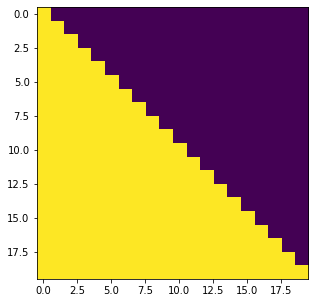

In [26]:
plt.figure(figsize=(5,5))

sub_mask = subsequent_mask(20)
print(sub_mask.shape)
plt.imshow(sub_mask[0])

이 마스크가 어떻게 적용되는지는 뒤에 상세히 예를 들어 설명하도록 하겠습니다.

### DecoderLayer와 Decoder

`DecoderLayer`와 `Decoder`의 구성은 인코더와 동일합니다. 한가지 다른 점은 `DecoderLayer`에는 어텐션이 두 개 있다는 점입니다. `forward()`함수를 보면 알 수 있듯이 셀프 어텐션과 인코더, 디코더 간의 크로스 어텐션입니다. 


In [27]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        # self_attn: MultiHeadedAttention
        # src_attn: MultiHeadedAttention

        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn # cross attention
        self.feed_forward = feed_forward # positional ff
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        # 여기서 momory는 인코더로 부터 넘어온 인코딩 (nbatche, n_seq, d_model)
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        
        # 크로스 어텐션 할 때 마스크는 src_mask(key_pad_mask)를 전달함!
        # 이렇게 하면 입력에 존재하는 패딩 토큰이 쿼리로써 인코딩되어 온 것을 
        # key 패딩으로 마스킹 할 수 있게 된다.
        # (인코더 출력이 이제는 key로 작용하기 때문에!!!)
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        
        return self.sublayer[2](x, self.feed_forward)

크로스 어텐션를 실행하는 코드를 보면 

```python
# x: 디코더에서 만든 (n_seq, d_mode) 텐서 (여기서 n_seq는 디코더로 입력되는 시퀀스의 길이)
# m: 인코더에서 전달받은 (n_seq, d_model) 텐서 (여기서 n_seq는 인코더로 입력된 시퀀스의 길이)
x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
```

셀프 어텐션과 차이는 쿼리로 디코더의 입력이 인코딩된 것을 넘기고 키와 벨류는 인코더에서 입력받는 인코딩 정보를 넘긴다는 것입니다. 이렇게 해야 크로스 어텐션이 계산되겠죠. 또 마스크는 `src_mask`를 넘기고 있는 것을 확인할 수 있습니다. 이에 대한 자세한 설명은 아래 [실험용 데이터와 보조 코드 준비](#cell-id)절에서 모두 설명하도록 하겠습니다.

아래는 `Decoder` 코드이고 특별히 언급할 점은 없습니다.

In [28]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        # layer: DecoderLayer

        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        
        # Encoder와 마찬가지로 norm 안함
        # return self.norm(x)
        return x

### 디코더 끝에 붙는 마지막 Linear 레이어

디코더의 출력을 받아서 최종적으로 $(n_{\text{seq}}, d_{\text{model}})$을 $(n_{\text{seq}}, \text{vocab})$로 변환하는 피드 포워드 레이어를 추가합니다.

In [29]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)



## Transformer

이상에서 만든 부품들로 트랜스포머를 조립합니다. `Encoder`, `Decoder`를 받아서 전체 모델을 생성하는 `EncoderDecoder` 클래스를 정의하고 이것을 객체로 생성하는 `make_model()` 함수를 정의합니다.

아래 그림은 `make_model()` 함수가 조립하는 전체 구조를 주석과 함께 나타낸 것입니다.

![picture](https://drive.google.com/uc?id=1aQKj79KnivzAaQ2pVz6103kQ1hf4klBQ)


In [30]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed # 인코더의 임베딩-위치인코딩
        self.tgt_embed = tgt_embed # 디코더의 임베딩-위치인코딩
        self.generator = generator

    # 이 함수가 모델이 포워드 되는 엔트리 포인트!!!    
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(
            self.encode(src, src_mask), src_mask,
            tgt, tgt_mask
        )
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

마지막으로 `Encoder`와 `Decoder`를 한번 더 감싸서 `EncoderDecoder` 클래스를 만듭니다. 이 클래스의 `forward`함수가 모델을 포워드시키는 엔트리 포인트가 됩니다.

In [31]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    """
        Helper: Construct a model from hyperparameters.
        src_vocab: 입력을 임베딩할 때 사용하는 단어장 사이즈
        tgt_vocab: 출력을 위한 출력쪽 단어장 사이즈
        d_mode: 트랜스포머 인코더 디코더에서 사용되는 벡터의 크기
        d_ff: feed foward층이 출력하는 벡터의 크기
    """
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        # 인코더를 만들기 위해 어텐선 레이어 하나와 피드포워드 레이어 하나가 필요합니다.
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        
        # 디코더를 만들기 위해 어텐션 레이어 두개와 피드포워드 레이어 하나가 필요합니다.
        # 두 어텐션 레이어 중 하나는 셀프 어텐션을 담당하고 하나는 크로스 어텐션을 담당합니다.
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),

        # 인코더와 디코더 쪽 임베딩으로 직접 만든 토큰 임베딩과
        # 포지션 인코딩을 순차적으로 수행하는 nn.Sequential                   
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),

        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            # nn.init.xavier_uniform(p)
            nn.init.xavier_uniform_(p)
    return model

마지막으로 트랜스포머를 조립하는 `make_model` 함수입니다. 지금까지 내용을 충분히 이해했다면 여기서 모델을 만드는 코드가 한눈에 들어올 것입니다.

`make_model` 함수의 각 부분이 그림의 어느 부분과 대응되는지 모두 그림으로 나타내었습니다.

![picture](https://drive.google.com/uc?id=1yOvDOXXr3hqHl_U9o2OfCXVDv8QEJbLE)

![picture](https://drive.google.com/uc?id=1yW4H4_xBcxWQROHo61g4Pke7xXtdYKCH)

![picture](https://drive.google.com/uc?id=1yXR2UYQr_LKLH12Q6lubZEhaw3EM78FM)

![picture](https://drive.google.com/uc?id=1yXlxXW4zowQPwkd1r9TvAIuWSNTzenKD)

![picture](https://drive.google.com/uc?id=1y_Lh9LUNZgXEfEhxrEsYN2NP3RtZBZ4k)

이상없이 모델이 만들어지는지 테스트 합니다.

In [32]:
# 무소식이 희소식! 아무 에러없이 실행되면 OK
tmp_model = make_model(10, 10, 2)


<a name="cell-id"></a>
## 실험용 데이터와 보조 코드 준비

이렇게 모델에 대한 코딩을 모두 마쳤고 이제 간단한 실험을 위한 코드를 알아보도록 하겠습니다. 먼저 `Batch`클래스입니다.

In [33]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        # src: (nbatches, n_seq_src)
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2) # (nbatches, 1, n_seq_src)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = self.make_std_mask(self.trg, pad) # (nbatches, n_seq_trg, n_seq_trg)
            self.ntokens = (self.trg_y != pad).data.sum() # 패딩 토큰이 아닌 토큰 수
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2) # (nbatches, 1, n_seq_trg)
        #tgt_mask = tgt_mask & Variable( subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data) )
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data)
        return tgt_mask

`Batch`클래스는 입력 시퀀스와 타겟 시퀀스를 받아서 입력과 타겟의 마스크를 만들고 타겟을 디코더에 입력되는 타겟(`self.trg`)과 출력 타겟(`self.trg_y`)으로 분리합니다. 예를 들면 다음과 같습니다.

- `src`: `I` `am` `a` `student.`

- `trg`: `나는` `학생` `입니다.`

    - `trg`: `나는` `학생`
    - `trg_y`: `학생` `입니다.`



다음으로 마스크를 만들게 되는데 마스크를 만드는 과정(`make_std_mask` 함수)은 코드만 봐서는 이해가 어려우므로 다음 예를 보면서 알아보겠습니다. 

이 글에서 어쩌면 가장 복잡하고 설명하기 지저분한 부분이니 잠시 쉬고 와서 읽도록 합시다. 😎

### Source mask (key pad mask)

먼저 source mask에 대해서 알아봅시다. 아래 예에서는 시퀀스 길이 5인 샘플 두 개가 (2,5)인 행렬에 들어있는 상황입니다.

예를 들어 각 샘플이 다음과 같다고 하겠습니다.

*   `i,     love,  you,   [PAD],  [PAD]`
*   `good,  job,  [PAD],  [PAD],  [PAD]`

이렇게 구성된 샘플에 셀프어텐션을 하는 경우 [PAD] 토큰에는 어텐션이 되면 안될 것입니다. 예를 들어 'i'와 관계가 있는 토큰을 알아내는 것이 셀프어텐션인데 그 후보 키 토큰에 [PAD]가 들어가는 것은 별로 바람직하지 않습니다. 물론 [PAD]가 쿼리로 작동하는 것도 피해야 합니다.따라서 [PAD] 가 있는 위치를 마스킹할 수 있는 마스크를 만들어야 합니다. 

마스크를 만들고 이를 직접 그림으로 보이는 것은 것은 트랜스포머 모델을 실제로 포워드 시켜야 하는 과정을 거쳐야 해서 매우 귀찮은 작업이지만 하나 하나 따라 가보도록 하겠습니다.😵

 단 문제를 단순화 하고 그림을 그리기 위해 헤드 하나를 가정합니다. 
우선 모델과 관련된 변수를 적당히 세팅합니다.


In [34]:
model_const = {'dv':3, 'dk':3, 'h':1, 'd_model':7, 'src_len':5, 'target_len':6}

In [35]:
pad = 0
# 길이 7인 샘플 두 개, src:(2,5)
# 1번 샘플은 길이 5, 패딩 2, 예를 들어 i     love  you   [PAD]  [PAD]  
# 2번 샘플은 길이 2, 패딩 3, 예를 들어 good  job  [PAD]  [PAD]  [PAD]
# 임의 숫자를 토큰 번호로 가정하고 randint를 사용
src = torch.from_numpy(np.random.randint(1, 100, size=(2, model_const['src_len'])))
paddings = torch.LongTensor([2, 3]).reshape(-1,1) # 각 샘플당 패딩 개수
pad_idx = src.shape[1] - paddings
col_idx = torch.arange(src.shape[1]).reshape(1,-1)
# src = src * ~(paddings > col_idx)
src = src * (pad_idx > col_idx)

# 마지막 토큰들은 PAD토큰이 되었음
print('src', src, '\n')

src tensor([[ 9, 21, 89,  0,  0],
        [92, 82,  0,  0,  0]]) 



이렇게 가상으로 만들어진 src에서 0인 자리를 `False`, 0이 아닌 자리를 `True`로 가지는 마스크를 생성합니다.

In [36]:
# (src != pad): (2,5)
# 패딩 토큰자리만 False인 src와 모양이 같은 마스크
print('\n(src != pad).shape', (src != pad).shape)
print(src != pad, '\n')


(src != pad).shape torch.Size([2, 5])
tensor([[ True,  True,  True, False, False],
        [ True,  True, False, False, False]]) 



이제 멀티헤드 어텐션에 마스크를 적용하기 위해 중간 차원을 하나 더 늘립니다.

In [37]:
src_mask_enc = (src != pad).unsqueeze(-2)
print('\n(src != pad).unsqueeze(-2).shape:', src_mask_enc.shape)
print(src_mask_enc)


(src != pad).unsqueeze(-2).shape: torch.Size([2, 1, 5])
tensor([[[ True,  True,  True, False, False]],

        [[ True,  True, False, False, False]]])


결과는 (2,5)인 마스크가 (2,1,5)가 되는데 마스크가 적용될 시점의 코드를 다시보면 

```python
# MultiHeadedAttention.forward()에서
    # Same mask applied to all h heads.
    mask = mask.unsqueeze(1)
    ...
    x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)

# attention()에서
    # scores: (nbatches, h, n_seq, n_seq)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
```

위 코드에서 `MultiHeadedAttention.forward()`를 거치면서 전달된 `src_mask`는 (2,1,5)가 (2,1,1,5)로 되며 이를 `(nbatches, h, n_seq, n_seq)`인 `score`에 적용하면 결국 h개 헤드에 행 방향으로만 마스크가 주어지게 됩니다. 

마스킹을 해서 그림을 그려보면


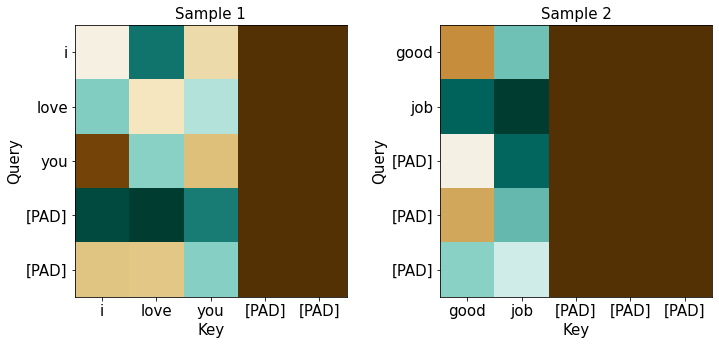

tensor([[[[0.4552, 0.8593, 0.3595, 0.0000, 0.0000],
          [0.6904, 0.3907, 0.6186, 0.0000, 0.0000],
          [0.0594, 0.6754, 0.2968, 0.0000, 0.0000],
          [0.9511, 0.9876, 0.8440, 0.0000, 0.0000],
          [0.3031, 0.3097, 0.6799, 0.0000, 0.0000]]],


        [[[0.1745, 0.5724, 0.0000, 0.0000, 0.0000],
          [0.7191, 0.7956, 0.0000, 0.0000, 0.0000],
          [0.3726, 0.7145, 0.0000, 0.0000, 0.0000],
          [0.2081, 0.5856, 0.0000, 0.0000, 0.0000],
          [0.5442, 0.4622, 0.0000, 0.0000, 0.0000]]]])


In [38]:
# 샘플 두개 헤드 하나짜리 (5,5)인 어텐션 스코어
encoder_self_attn_scores = torch.rand((2, 1, model_const['src_len'], 
                                       model_const['src_len']))
src_mask_enc_reshape = src_mask_enc.unsqueeze(1)

# -1e9로 마스킹을 하면 마스킹 되지 않는 부분이 모두 같은 색으로 
# 나타나므로 여기서는 그냥 0으로 마스킹
masked_encoder_self_attn_scores = encoder_self_attn_scores.masked_fill(
    src_mask_enc_reshape == 0, 0)

fig, ax = plt.subplots(figsize=(12,5), nrows=1, ncols=2)

ax[0].imshow(masked_encoder_self_attn_scores[0][0], cmap='BrBG')
ax[0].set_xticks([0, 1, 2, 3, 4])
ax[0].set_xticklabels(['i', 'love', 'you', '[PAD]', '[PAD]'], fontsize=15)
ax[0].set_xlabel('Key', fontsize=15)
ax[0].set_yticks([0, 1, 2, 3, 4])
ax[0].set_yticklabels(['i', 'love', 'you', '[PAD]', '[PAD]'], fontsize=15)
ax[0].set_ylabel('Query', fontsize=15)
ax[0].set_title('Sample 1', fontsize=15)

ax[1].imshow(masked_encoder_self_attn_scores[1][0], cmap='BrBG')
ax[1].set_xticks([0, 1, 2, 3, 4])
ax[1].set_xticklabels(['good', 'job', '[PAD]', '[PAD]', '[PAD]'], fontsize=15)
ax[1].set_xlabel('Key', fontsize=15)
ax[1].set_yticks([0, 1, 2, 3, 4])
ax[1].set_yticklabels(['good', 'job', '[PAD]', '[PAD]', '[PAD]'], fontsize=15)
ax[1].set_ylabel('Query', fontsize=15)
ax[1].set_title('Sample 2', fontsize=15)

plt.show()

print(masked_encoder_self_attn_scores)

[PAD]에 해당하는 열만 마스킹되었습니다. 어텐션 스코어 행렬에서 행은 쿼리에, 열은 키에 해당하는데 이렇게 마스킹되는 것은 결국 키만 마스킹 했다는 의미입니다. 다시말해  i, love, you, [PAD], [PAD]라는 단어 다섯개를 쿼리로 요청하였고 그에 대한 응답으로 [PAD] 두개는 마스킹하고 i, love, you만 키가 되어 요청된 쿼리와 가중치가 계산된 것입니다.

어차피 필요없는 [PAD]를 왜 쿼리로 요청했는지 이상할 수 있습니다. 그 이유는 이렇게 키만 마스킹된 인코딩 정보가 디코더로 넘어가 크로스 어텐션될 때는 다시 키로 작용하게 되는데 그때 키가 $K^T$로 전치 되면서 다시 한번 마스킹을 적용하면 마스킹 되지 않았던 쿼리에 대한 [PAD]도 마스킹되어 사라지기 때문입니다. 

이런 이유 때문에 이 소스코드에서 `src_mask`가 PyTorch에서는 `key_padding_mask`라는 이름으로 제공됩니다.

> key_padding_mask: If specified, a mask of shape (N,S) indicating which elements within key to ignore for the purpose of attention (i.e. treat as  padding”). 

해당 과정은 설명의 마지막 부분에서 구체적인 예를 들어 직접 코드로 확인하겠습니다.

### Target mask

다음은 타겟쪽 마스크를 알아보겠습니다. 타겟 마스크도 먼저 [PAD] 위치를 마스킹 합니다. 이 과정은 앞서 알아본 `src_mask`와 동일합니다. 타겟 데이터는 소스가 번역된 다음 문장으로 가정합니다.


*   `나는,  당신을,  사랑,   합니다, [PAD], [PAD], [PAD]`
*   `잘,    했어,    [PAD],  [PAD],  [PAD], [PAD], [PAD]`

In [39]:
# 디코더에 입력될 타겟을 준비한다. 
# shape: (2,6)
# 임의 숫자를 토큰 번호로 가정하고 randint를 사용
trg = torch.from_numpy(np.random.randint(1, 100, size=(2, model_const['target_len'])))
paddings = torch.LongTensor([2, 4]).reshape(-1,1) # 각 샘플당 패딩 개수
pad_idx = trg.shape[1] - paddings
col_idx = torch.arange(trg.shape[1]).reshape(1,-1)
# src = src * ~(paddings > col_idx)
trg = trg * (pad_idx > col_idx)

# 마지막 토큰들은 PAD토큰이 되었음
print('trg', trg, '\n')

# src때와 마찬가지로 패딩 토큰자리만 False인 trg와 모양이 같은 마스크
# shape: (2,6)
print('(trg != pad).shape', (trg != pad).shape)
print(trg != pad, '\n')

# src_mask때와 마찬가지로 차원을 늘린다.
# subsequent_mask()에서 출력된 마스크와 브로드캐스팅된다.
# (2,1,6)
print('(trg != pad).unsqueeze(-2).shape', (trg != pad).unsqueeze(-2).shape)
trg_mask = (trg != pad).unsqueeze(-2)
print(trg_mask, '\n')

trg tensor([[13, 22, 25, 50,  0,  0],
        [99, 92,  0,  0,  0,  0]]) 

(trg != pad).shape torch.Size([2, 6])
tensor([[ True,  True,  True,  True, False, False],
        [ True,  True, False, False, False, False]]) 

(trg != pad).unsqueeze(-2).shape torch.Size([2, 1, 6])
tensor([[[ True,  True,  True,  True, False, False]],

        [[ True,  True, False, False, False, False]]]) 



디코더 쪽에서 사용하는 타겟 마스크는 앞서 설명한 셀프 어텐션에 대한 마스킹도 함께 해야 하므로 `subsequnent_mask()`에서 생성된 마스크 행렬과 & 연산을 해줍니다.

In [40]:
# 입력 타켓으로 subsequent_mask 마스크 행렬을 만든다.
# shape: (1, 6, 6)
self_attn_mask = subsequent_mask(trg.size(-1)).type_as(trg_mask.data)
print('self_attn_mask.shape => ', self_attn_mask.shape)
print( self_attn_mask, '\n')

# 패딩 토큰 자리가 False인 trg_mask와 subsequent_mask()의 결과를 & 한다.
# 다음 브로드캐스팅되는 과정이 있고 늘어나는 차원은 []로 표시했다.
# (2,1,6) & (1, 6, 6) => (2, [6], 6) & ([2], 6, 6)
trg_mask_dec = trg_mask & self_attn_mask
print('trg_mask_dec')    
print( trg_mask_dec )

self_attn_mask.shape =>  torch.Size([1, 6, 6])
tensor([[[ True, False, False, False, False, False],
         [ True,  True, False, False, False, False],
         [ True,  True,  True, False, False, False],
         [ True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True,  True]]]) 

trg_mask_dec
tensor([[[ True, False, False, False, False, False],
         [ True,  True, False, False, False, False],
         [ True,  True,  True, False, False, False],
         [ True,  True,  True,  True, False, False],
         [ True,  True,  True,  True, False, False],
         [ True,  True,  True,  True, False, False]],

        [[ True, False, False, False, False, False],
         [ True,  True, False, False, False, False],
         [ True,  True, False, False, False, False],
         [ True,  True, False, False, False, False],
         [ True,  True, False, False, False, False],
         [ True,  True, False, Fa

위 코드의 주석을 읽고 마지막 출력 결과를 보면 패딩 토큰이 있는 행과 열은 모두 False이고 데이터가 있는 자리만 작게 하삼각 행렬이 True인 부분 행렬이 마스크로 만들어짐을 확인할 수 있습니다.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45716 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45817 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49888 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51012 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_

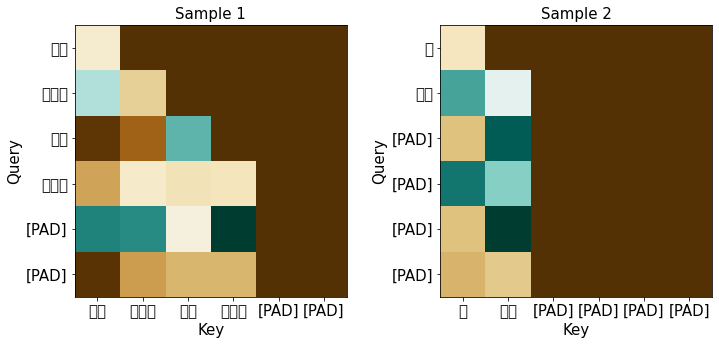

In [41]:
# 샘플 두개 헤드 하나짜리 (6,6)인 어텐션 스코어
decoder_self_attn_scores = torch.rand((2, 1, 6, 6))
trg_mask_dec_reshape = trg_mask_dec.unsqueeze(1)

# -1e9로 마스킹을 하면 마스킹 되지 않는 부분이 모두 같은 색으로 
# 나타나므로 여기서는 그냥 0으로 마스킹
masked_decoder_self_attn_scores = decoder_self_attn_scores.masked_fill(trg_mask_dec_reshape == 0, 0)

fig, ax = plt.subplots(figsize=(12,5), nrows=1, ncols=2)

ax[0].imshow(masked_decoder_self_attn_scores[0][0], cmap='BrBG')
ax[0].set_xticks([0, 1, 2, 3, 4, 5])
ax[0].set_xticklabels(['나는', '당신을', '사랑', '합니다', '[PAD]', '[PAD]'], fontsize=15)
ax[0].set_xlabel('Key', fontsize=15)
ax[0].set_yticks([0, 1, 2, 3, 4, 5])
ax[0].set_yticklabels(['나는', '당신을', '사랑', '합니다', '[PAD]', '[PAD]'], fontsize=15)
ax[0].set_ylabel('Query', fontsize=15)
ax[0].set_title('Sample 1', fontsize=15)

ax[1].imshow(masked_decoder_self_attn_scores[1][0], cmap='BrBG')
ax[1].set_xticks([0, 1, 2, 3, 4, 5])
ax[1].set_xticklabels(['잘', '했어', '[PAD]', '[PAD]', '[PAD]', '[PAD]'], fontsize=15)
ax[1].set_xlabel('Key', fontsize=15)
ax[1].set_yticks([0, 1, 2, 3, 4, 5])
ax[1].set_yticklabels(['잘', '했어', '[PAD]', '[PAD]', '[PAD]', '[PAD]'], fontsize=15)
ax[1].set_ylabel('Query', fontsize=15)
ax[1].set_title('Sample 2', fontsize=15)

plt.show()

마스킹된 그림을 보면 셀프 어텐션에 대한 마스킹 때문에 상삼각행렬에 해당하는 요소가 모두 마스킹되었고 타겟에 있는 [PAD]에 대해서 열방향으로 마스킹 된 것을 확인할 수 있습니다.

이제 마지막으로 디코더에서 일어나는 크로스 어텐션에 대한 마스크를 확인하도록 하겠습니다. 이를 위해 적당히 (nbatches=2, head=1, dv=5) 크기를 가지는 벨류 텐서를 만들고 앞서 소스 마스크에서 만들어 놓은 `masked_encoder_self_attn_scores` 텐서와 곱해 헤드를 만듭니다.
그 다음 임의로 초기화 된 $W^o$행렬과 곱해서 최종 인코딩을 만듭니다.

In [ ]:
V = torch.rand((2, model_const['h'], model_const['src_len'], model_const['dv']))
# head가 하나 뿐이라 concat 할 필요없이 squeeze()합니다.
head = torch.matmul(masked_encoder_self_attn_scores, V).squeeze() 
Wo = torch.rand(model_const['dv']*model_const['h'], model_const['d_model'])
encoding_src = torch.matmul(head, Wo)

print(encoding_src.shape)
print(encoding_src)

torch.Size([2, 5, 7])
tensor([[[1.3157, 0.8231, 1.8169, 2.2399, 0.7467, 0.7838, 0.9017],
         [1.0317, 0.6436, 1.4306, 1.7503, 0.5839, 0.5992, 0.7001],
         [1.7735, 1.1149, 2.3128, 2.7675, 1.1070, 0.8919, 1.2505],
         [2.4297, 1.5170, 3.2814, 3.9383, 1.4432, 1.2764, 1.6642],
         [0.5630, 0.3511, 0.7676, 0.9250, 0.3292, 0.3033, 0.3835]],

        [[0.7225, 0.4850, 0.8106, 1.1491, 0.5061, 0.5566, 0.6293],
         [0.7500, 0.5038, 0.8479, 1.2112, 0.5195, 0.5941, 0.6536],
         [0.7592, 0.5096, 0.8507, 1.2044, 0.5327, 0.5821, 0.6612],
         [0.7580, 0.5088, 0.8508, 1.2065, 0.5306, 0.5848, 0.6602],
         [0.3948, 0.2652, 0.4466, 0.6385, 0.2731, 0.3136, 0.3440]]])


이렇게 만들어진 인코딩에서 4행과 5행은 [PAD]가 인코딩된 정보임을 상기 합시다. 이제 디코더 쪽에서 타겟에 대한 인코딩을 동일한 방식으로 만듭니다.

In [ ]:
V = torch.rand((2, 1, model_const['target_len'], model_const['dv']))
head = torch.matmul(masked_decoder_self_attn_scores, V).squeeze()
Wo = torch.rand(model_const['dv']*model_const['h'], model_const['d_model'])
encoding_trg = torch.matmul(head, Wo)

print(encoding_trg.shape)
print(encoding_trg)

torch.Size([2, 6, 7])
tensor([[[0.1092, 0.2553, 0.2908, 0.3739, 0.3702, 0.1855, 0.0366],
         [0.6836, 1.0122, 1.1891, 1.4366, 1.6190, 0.8272, 0.2952],
         [0.2467, 0.5165, 0.5903, 0.7477, 0.7585, 0.3868, 0.0951],
         [1.0650, 1.6200, 1.7648, 1.9914, 2.1176, 1.4748, 0.8864],
         [1.5561, 2.6366, 2.8497, 3.2805, 3.3495, 2.3318, 1.3270],
         [0.8810, 1.3566, 1.5207, 1.7734, 1.9178, 1.1775, 0.5928]],

        [[0.5224, 0.7097, 0.7051, 0.6843, 0.7026, 0.7583, 0.6666],
         [0.3033, 0.5964, 0.5850, 0.6280, 0.5492, 0.5731, 0.4405],
         [0.5860, 0.8012, 0.7957, 0.7740, 0.7920, 0.8543, 0.7493],
         [0.2773, 0.5113, 0.5024, 0.5316, 0.4760, 0.4994, 0.3928],
         [1.1601, 1.9902, 1.9602, 2.0378, 1.8777, 1.9823, 1.6005],
         [0.7322, 1.0746, 1.0643, 1.0591, 1.0460, 1.1204, 0.9576]]])


이제 `encoding_src`를 키와 벨류로 사용하고 `encoding_trg`를 쿼리로 사용해서 어텐션합니다. 이때 어텐션 마스크는 소스 마스크인 `src_mask_enc_reshape`를 사용합니다.

`encoding_src`와 `encoding_trg`가 `MultiHeadedAttention.forward()`로 입력되면 앞서 알아본과정을 통해 이 인코딩들도 멀티헤드 쿼리, 키, 벨류로 바뀌게 됩니다. 여기서는 이 과정을 거쳤다고 가정하고 바로 텐서를 (nbatches, h, n_seq, d_k)로 변환하여 사용하겠습니다.

변환된 두 인코딩 텐서를 어텐션 연산하고 마스크를 적용합니다.



In [ ]:
multiheaded_encoding_src = encoding_src.unsqueeze(1)
multiheaded_encoding_trg = encoding_trg.unsqueeze(1)

cross_QKt = torch.matmul(multiheaded_encoding_trg, 
                         multiheaded_encoding_src.transpose(3,2))

print('cross_QKt shape =>', cross_QKt.shape)
print(cross_QKt)

masked_cross_QKt = cross_QKt.masked_fill(src_mask_enc_reshape == 0, 0)
print(masked_cross_QKt)

cross_QKt shape => torch.Size([2, 1, 6, 5])
tensor([[[[ 2.1746,  1.7004,  2.8068,  3.9115,  0.9124],
          [ 9.2343,  7.2198, 11.9659, 16.6396,  3.8791],
          [ 4.4522,  3.4812,  5.7513,  8.0110,  1.8685],
          [13.9381, 10.8922, 18.0558, 25.0925,  5.8496],
          [22.2684, 17.4027, 28.8159, 40.0696,  9.3428],
          [11.9004,  9.3017, 15.4144, 21.4298,  4.9960]]],


        [[[ 3.2766,  3.4272,  3.4387,  3.4388,  1.8053],
          [ 2.5783,  2.6983,  2.7056,  2.7060,  1.4214],
          [ 3.6942,  3.8640,  3.8769,  3.8770,  2.0354],
          [ 2.2324,  2.3361,  2.3427,  2.3429,  1.2306],
          [ 8.7947,  9.2023,  9.2293,  9.2301,  4.8475],
          [ 4.8854,  5.1106,  5.1270,  5.1272,  2.6920]]]])
tensor([[[[ 2.1746,  1.7004,  2.8068,  0.0000,  0.0000],
          [ 9.2343,  7.2198, 11.9659,  0.0000,  0.0000],
          [ 4.4522,  3.4812,  5.7513,  0.0000,  0.0000],
          [13.9381, 10.8922, 18.0558,  0.0000,  0.0000],
          [22.2684, 17.4027, 28.8159,

적용된 결과를 그려보면...

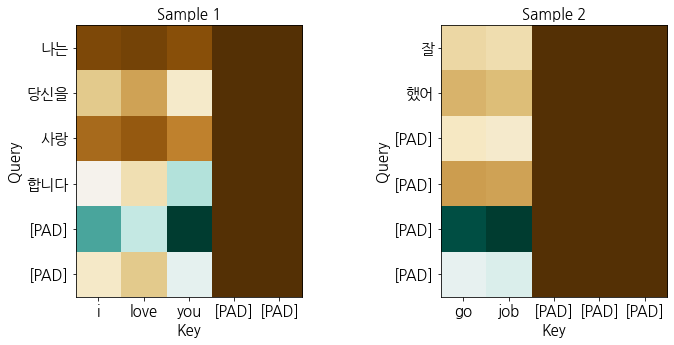

In [ ]:
fig, ax = plt.subplots(figsize=(12,5), nrows=1, ncols=2)

ax[0].imshow(masked_cross_QKt[0][0], cmap='BrBG')
ax[0].set_xticks([0, 1, 2, 3, 4])
ax[0].set_xticklabels(['i', 'love', 'you', '[PAD]', '[PAD]'], fontsize=15)
ax[0].set_xlabel('Key', fontsize=15)
ax[0].set_yticks([0, 1, 2, 3, 4, 5])
ax[0].set_yticklabels(['나는', '당신을', '사랑', '합니다', '[PAD]', '[PAD]'], fontsize=15)
ax[0].set_ylabel('Query', fontsize=15)
ax[0].set_title('Sample 1', fontsize=15)

ax[1].imshow(masked_cross_QKt[1][0], cmap='BrBG')
ax[1].set_xticks([0, 1, 2, 3, 4])
ax[1].set_xticklabels(['go', 'job',  '[PAD]', '[PAD]', '[PAD]'], fontsize=15)
ax[1].set_xlabel('Key', fontsize=15)
ax[1].set_yticks([0, 1, 2, 3, 4, 5])
ax[1].set_yticklabels(['잘', '했어', '[PAD]', '[PAD]', '[PAD]', '[PAD]'], fontsize=15)
ax[1].set_ylabel('Query', fontsize=15)
ax[1].set_title('Sample 2', fontsize=15)

plt.show()


드디어 😲 타겟의 쿼리 '나는', '당신을', '사랑', '합니다', '[PAD]', '[PAD]'가 소스쪽 키 'i', 'love', 'you'와 어텐션되는 것을 확인할 수 있습니다! 인코더에서 [PAD]가 인코딩되어 온 정보는 디코더쪽 크로스 어텐션에서 비로소 패딩되어 사라지는 것을 확인할 수 있습니다.

<a name="cell-id-targetmask"></a>
그럼 쿼리로 쓰이는 타겟에 포함된 [PAD]는 언제 마스킹 될까요? 이 [PAD]는 로스를 계산할 때 마스킹되게 됩니다. 그 과정이 아래쪽 [Label Smoothing](#cell-id-labelsmoothing) 절에 나와 있습니다.



## Coffe Break

트랜스포머를 이해하는데 있어 매우 귀찮은 마스킹을 완전히 분석했습니다. 여기까지 읽고 내용을 머리에 그릴 수 있다면 이제 글을 더 읽지 말고 커피나 음료수를 마시면서 쉬도록 합시다. 나머지는 내일 읽어주셔도 됩니다. 😁

## 장난감 데이터 생성함수

원문에서는 아래 함수처럼 입력과 출력이 동일한 무작위 숫자를 열개 생성하여 입력이 들어갔을 때 제대로 출력이 나오는지 체크합니다.

In [42]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = data; src.requires_grad=False
        tgt = data; tgt.requires_grad=False
        yield Batch(src, tgt, 0)

입력과 동일한 출력이 나오는 예제는 너무 재미가 없으니 여기서는 이 예제를 살짝 바꿔서 길이 10짜리 무작위 숫자를 입력으로 사용하는 것은 똑같으나 출력은 5번부터 10번 숫자 즉 뒤쪽 절반에 +1을 한 것을 출력으로 설정하겠습니다.

예를 들면 다음과 같습니다.

```
- 입력: 1 2 3 4 5 6 7 8  9 10
- 출력: 1 2 3 4 5 7 8 9 10 11
```

간단하게 데이터를 생성하는 함수를 만듭니다.

In [43]:
def data_gen2(V, batch, nbatches):
    """
    무작위 데이터를 생성하는데
    데이터 길이의 뒷 절반에 +1 한 것이 정답 벡터인 데이터를 생성한다.
    V: 단어장에 단어수
    batch: 한 미니배치에 샘플 수
    nbatches: 한 에폭에 있는 미니배치 수
    """
    for i in range(nbatches):
        # 샘플하나당 시퀀스 길이는 10으로 고정
        data = torch.from_numpy(np.random.randint(1, V-1, size=(batch, 10)))
        data.requires_grad = False
        data[:, 0] = 1
        
        src = data.clone() 
        tgt = data.clone()
        # 뒤에 다섯개는 +1
        tgt[:, V//2:] +=1 
        
        yield Batch(src, tgt, 0)

In [44]:
# data_gen2가 제대로 작동하는지 확인
# 단어수: 11, 미니배치사이즈:1, 에폭당 미니배치:10
for data in data_gen2(11, 1, 10) :
    # 입력, teach_forcing의 입력, teach_forcing의 출력
    print('data.src: ', data.src)
    print('data.src_mask: ', data.src_mask)
    print('data.trg: ', data.trg)
    print('data.trg_y: ', data.trg_y)
    print('data.trg_mask\n', data.trg_mask)

data.src:  tensor([[1, 6, 9, 2, 7, 4, 3, 4, 3, 1]])
data.src_mask:  tensor([[[True, True, True, True, True, True, True, True, True, True]]])
data.trg:  tensor([[1, 6, 9, 2, 7, 5, 4, 5, 4]])
data.trg_y:  tensor([[6, 9, 2, 7, 5, 4, 5, 4, 2]])
data.trg_mask
 tensor([[[ True, False, False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False, False],
         [ True,  True,  True,  True, False, False, False, False, False],
         [ True,  True,  True,  True,  True, False, False, False, False],
         [ True,  True,  True,  True,  True,  True, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True]]])
data.src:  tensor([[1, 8, 1, 9, 5, 7, 1, 7, 2, 4]])
data.src_mask:  tensor([

미니배치 내 샘플들을 최대 길이로 잘라주는 함수입니다.

In [45]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

## Learning Rate Warm Up

$$
lrate = d^{-0.5}_{\text{model}}\cdot \min \left({step\_num}^{-0.5}, {step\_num} \cdot  {warmup\_steps}^{-1.5} \right)
$$

학습중 학습률을 위 식처럼 변경합니다. 식에서 $step\_num$은 옵티마이저가 파라미터를 한번 업데이트할 때마다 1 증가하는 진행 스탭수를 나타냅니다. 학습 초기에는 $step\_num$이 작기 때문에 다음과 같습니다.

$$
{step\_num} \cdot  {warmup\_steps}^{-1.5} = \min \left({step\_num}^{-0.5}, {step\_num} \cdot  {warmup\_steps}^{-1.5} \right)
$$

즉 $step\_num$이 증가함에 따라 선형적으로 학습률이 증가합니다. $step\_num$이 계속 증가하다가 $step\_num =  warmup\_steps$가 되면 $\min$ 안에 두 항은 같아지게 되고 그 다음 스탭부터 

$$
{step\_num}^{-0.5} = \min \left({step\_num}^{-0.5}, {step\_num} \cdot  {warmup\_steps}^{-1.5} \right)
$$

가 되어 $step\_num$의 제곱에 반비례하게 학습률이 천천히 줄어들게 됩니다. 코드를 보면 전체적으로 학습률의 크기를 조정하기 위해 모델 사이즈와 별도의 factor를 곱하는 것을 확인할 수 있습니다.


In [46]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        # 초기에는 min( , )에서 뒷부분이 작동하여 step에 선형적으로 lr이 증가
        # 그렇게 뒷 부분이 자꾸 커지다 step에 self.warmup과 같아지면
        # 뒷부분이 step*step**(-1.5)=step**(-0.5)가 되고 
        # step = self.warmup+1부터는 앞부분이 작아져서
        # 어느 순간 step의 제곱근에 반비례하게 lr이 줄어듬
        return self.factor * \
            (self.model_size ** (-0.5) * 
             min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

모델 사이즈 512, 256, 웜업스탭 4000, 8000인 경우에 대해서 학습률이 어떻게 변화하는지 그래프로 그리면 아래와 같습니다.

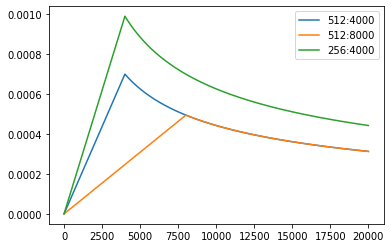

In [47]:
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

<a name="cell-id-labelsmoothing"></a>
## Label Smoothing

예측을 할 때 정답이라고 예측된 토큰에 거의 확률 1로 예측하는 것을 막기위해 레이블을 깍아주는 작업을 하면 예측 성능이 더 좋아지는 것으로 알려져 있습니다.

아래 원문처럼 0, 1로 구성된 확률 분포를 정답 분포로 쓰지 않고 정답자리 확률을 0.8정도로 깍아내리고 깍아낸 0.2를 나머지 오답 자리에 고루 분배하여 정답 분포를 마치 '신뢰도'정도로 해석할 수 있게 하는 방식입니다.

> We implement label smoothing using the KL div loss. Instead of using a one-hot target distribution, we create a distribution that has `confidence` of the correct word and the rest of the `smoothing` mass distributed throughout the vocabulary.

In [48]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        
        # size_average and reduce are in the process of being deprecated, 
        # and in the meantime, specifying either of those two args will override reduction.
        # self.criterion = nn.KLDivLoss(size_average=False)
        
        # smoothing을 적용한 타겟과 로스를 구하므로 NLLLoss 대신 KLDivLoss 사용
        self.criterion = nn.KLDivLoss(reduction='sum') # input: log-probabilities 
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        # x: model.generator에서 출력한 log_softmax 값

        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2)) # 정답자리와 패딩자리 두자리 빼고
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        # 여기까지 스무딩 시켰고...
        
        # 패딩 토큰 위치는 확률을 0으로 지정
        true_dist[:, self.padding_idx] = 0
        
        # target이 패팅토큰 번호라면 그 데이터에 대해서는 로스를 구할 필요
        # 없으므로 모든 확률분포자리를 0으로 만들어 버림
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            # index_fill_(dim, index, val): dim차원을 따라 index가 지정된 위치에 val을 채움
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist

        # loss 계산
        return self.criterion(x, true_dist)

늘 그렇듯이 위 코드를 보면 또 이해가 쉽지 않습니다. 그래서 하나씩 뜯어서 알아보도록 하겠습니다. 간단한 예제를 위해 단어장 크기가 5라고 가정하겠습니다. `smoothing=0.4`로 두면 다음처럼 시작할 수 있습니다.

In [49]:
size = 5
smoothing = 0.4
# 정답자리가 가져갈 확률 원래는 1인데 (1-smoothing)으로 깍아버리고
# 깍은 만큼(smoothing)을 오답자리에 동일하게 나눠 주는 작업을 시작
confidence = 1- smoothing 
padding_idx = 0

총 세 개 샘플에 대해서 다음처럼 예측이 나왔다고 하겠습니다.

In [50]:
# 예측은 2번, 2번, 2번 토큰으로 예측
# 총 다섯개의 토큰이 있고 0번 토큰은 [PAD], 1~4번 토큰은 일반 토큰
#              토큰위치 0    1    2    3   4  
x = torch.FloatTensor([[0, 0.2, 0.7, 0.1,  0],
                       [0, 0.2, 0.7, 0.1,  0], 
                       [0, 0.2, 0.7, 0.1,  0]])

세 개 샘플에 대해서 모두 2번 단어가 정답이라고 예측한 상황입니다. 그리고 정답 타겟은 (2, 0, 0)이라고 가정하겠습니다. 측 첫 샘플만 2번 단어가 정답이고 나머지 뒤 두개는 패딩 토큰인 상황입니다. 각 샘플에 대한 정답 분포르 만듭니다. 원래 정답분포는 다음과 같아야 하지만

$$
\begin{bmatrix}
0 & 0& 1& 0& 0 \\
1& 0& 0& 0& 0 \\
1& 0& 0& 0& 0 \\
\end{bmatrix}
$$

smoothing을 통해 어떻게 변하는지 확인해보기로 합시다.

In [51]:
# 타겟은 2, 0, 0
target  = torch.LongTensor([2,0,0])
true_dist = x.clone()

# 정답1개, 패딩1개 해서 -2
# 여기서 smoothing을 정답과 패딩 토큰 위치를 제외한 나머지 토큰들에게
# 나눠준다.
true_dist.fill_(smoothing / (size-2)) 

# 정답자리에는 confidence, 여기선 0.6을 대입
#                  1번축을 따라
#                     이 인덱스에 해당하는 위치에
#                                               confidence값을 대입
true_dist.scatter_(1, target.data.unsqueeze(1), confidence)
print(true_dist)

tensor([[0.1333, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.6000, 0.1333, 0.1333, 0.1333, 0.1333],
        [0.6000, 0.1333, 0.1333, 0.1333, 0.1333]])


계산된 `true_dist`는 원래 정답분포가 0인 자리에 `(1-smoothing) / 3`값이 들어가고 1인 자리에 `smoothing`값이 들어간것을 확인할 수 있습니다.

이제 나머지 작업을 수행합니다. 패딩 토큰에 0.6이라는 확률이 부여 되어 있는데 패딩 토큰은 예측할 일이 없으니 0으로 만듭니다. 그리고 정답이 패딩토큰인 샘플은 모든 자리를 0으로 만들어 버립니다. 

[Target mask] 절에서 최종적으로 마스킹된 결과에 디코더에서 입력된 [PAD] 토큰 위치는 마스킹하지 않고 그대로 둔 것이 기억 나시나요? 기억이 잘나지 않으면 [여기](#cell-id-targetmask)를 클릭해서 다시 돌아가봅시다. 



In [52]:
# 예측 벡터의 길이는 단어장 단어 개수와 같은데 
# 패딩 토큰은 예측할 일이 없으니 패딩 토큰 자리는 확률을 0으로 지정
true_dist[:, padding_idx] = 0 
print(true_dist)

# target이 패딩되어 있어서 (타겟도 시퀀스니까 미니배치 안에서 패딩될 수 있음)
# [2, padding_idx, padding_idx]처럼 target이 생겼는데
# target에서 padding_idx가 나타나는 위치에 예측 벡터는 모조리 0으로 채움
# 이렇게 하면 2번, 3번 데이터는 로스 계산에서 빠짐
# torch.nonzero(..., as_tuple=False) 
# (default) returns a 2-D tensor where each row is the index for a nonzero value.
print(target.data == padding_idx)
mask = torch.nonzero(target.data == padding_idx) # 정답이 패딩인덱스와 같은 데이터 번호
print(mask)
print(mask.squeeze())

# index_fill_(dim, index, val): dim차원을 따라 index가 지정된 위치에 val을 채움
true_dist.index_fill_(0, mask.squeeze(), 0.0)
print(true_dist)

tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.1333, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.1333, 0.1333, 0.1333, 0.1333]])
tensor([False,  True,  True])
tensor([[1],
        [2]])
tensor([1, 2])
tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


마지막에 출력된 결과 텐서를 보면 1행만 smoothing된 확률분포가 들어있고 [PAD] 토큰에 해당하는 2, 3행은 모두 0으로 채워진 것을 볼 수 있습니다. 이렇게 해서 마스킹에 대한 세부 사항이 모두 정리가 되었습니다. 🥳

위 `LabelSmoothing` 클래스는 이 코드들을 하나로 묶에 놓은 것입니다.  `LabelSmoothing`클래스를 이용해서 실제로 smoothing하는 예제가 아래 있습니다.

tensor([[0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
tensor([[0.0000, 0.1333, 0.6000, 0.1333, 0.1333],
        [0.0000, 0.6000, 0.1333, 0.1333, 0.1333],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])


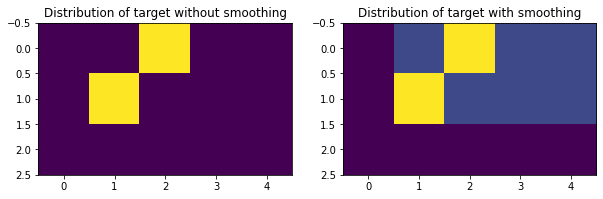

In [53]:
# Example of label smoothing.
# 단어장 크기가 5인데 0번 단어는 패딩토큰
crit1 = LabelSmoothing(5, 0, 0.0)
crit2 = LabelSmoothing(5, 0, 0.4)

# 예측은 2번, 2번, 2번 토큰으로 예측
# 총 다섯개의 토큰이 있고 0번 토큰은 [PAD], 1~4번 토큰은 일반 토큰
#                    토큰위치 0    1    2    3   4  
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1,  0],
                             [0, 0.2, 0.7, 0.1,  0], 
                             [0, 0.2, 0.7, 0.1,  0]])
# 정답은 2번, 1번, 0번, 즉 마지막 단어는 패딩토큰이 정답이라면
v1 = crit1(predict.log(), torch.LongTensor([2, 1, 0]))
v2 = crit2(predict.log(), torch.LongTensor([2, 1, 0]))

# Show the target distributions expected by the system.
# 결과를 보면 패딩토큰 자리는 모두 0 (1번 열)
# target에서 패딩된 단어에 해당하는 예측 3행은 모든 자리가 0
fig, ax = plt.subplots(figsize=(10,5), nrows=1, ncols=2)

ax[0].set_title("Distribution of target without smoothing")
print(crit1.true_dist)
ax[0].imshow(crit1.true_dist)

ax[1].set_title("Distribution of target with smoothing")
print(crit2.true_dist)
ax[1].imshow(crit2.true_dist)
plt.show()

`LabelSmoothing` 클래스에서 정답 분포를 smoothing하고 나서 로스 까지 계산하므로 정답자리에 대한 확신이 점점 1에 가까워지면 로스가 어떻게 계산되는지 확인해볼 수 있습니다.

>Label smoothing actually starts to penalize the model if it gets very confident about a given choice.

아래 코드셀에서 `x`가 커지면 `x/d`가 점점 1에 가깝게 되고 그렇게 되면 로스 값이 조금씩 증가하는 것을 볼 수 있습니다.

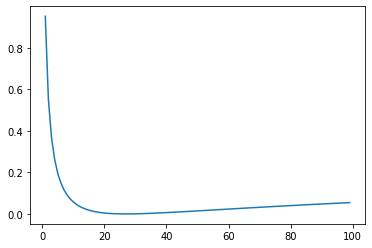

In [54]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1

    predict = torch.FloatTensor([[0, x/d, 1/d, 1/d, 1/d]])
    
    return crit(predict.log(), torch.LongTensor([1]))#.data[0]

plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

## Loss 계산

`LabelSmoothing`에서 smoothing 뿐만 아니라 `nn.KLDivLoss`를 사용해서 로스값을 계산합니다. 원래 정답분포는 정답자리만 1이고 나머지는 모두 0입니다. 이럴 때 주로 사용하는 손실함수는 `nn.NLLLoss`입니다. 하지만 `LabelSmoothing`이 정답분포를 부드럽게 깍았으므로 모든 오답자리에도 확률이 할당되어 있습니다. 이럴때 출력분포와 정답분포의 차이를 계산하기 위해 Kullback–Leibler divergence[[7](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)]를 사용합니다. `SimpleLossCompute`는 `model.generator`를 호출해서 모델의 출력값을 계산한다음 그 값을 `LabelSmoothing`에 넘겨 로스값을 받아오고 백워드까지 수행합니다.

In [55]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        # 여기서 generator는 model.generator
        self.generator = generator
        
        # 여기서 criterion은 LabelSmoothing 
        self.criterion = criterion

        self.opt = opt
        
    def __call__(self, x, y, norm):
        # norm은 batch에서 토큰 수
        # self.ntokens = (self.trg_y != pad).data.sum() # 패딩 토큰이 아닌 토큰 수
        
        x = self.generator(x)
        
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        # return loss.data[0] * norm
        return loss * norm

## 학습

모든 설명이 끝이 났습니다! 이제 적당히 학습 함수를 정의하고 학습을 하면 됩니다.



In [56]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    # data_iter를 만들 때 설정한 nbatches 만큼 루프를 돈다. 즉 1에폭
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        
        # 여기서 loss_compute()는 SimpleLossCompute 임
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d, Loss: %f, Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [57]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
#                   model_size, factor, warmup, optimizer
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 1200,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(18):
    model.train()
    print(f'{epoch} epoch train')
    run_epoch(data_gen2(V, 30, 20), model, # 미니배치에 샘플 30개씩 20배치가 한에폭 
              SimpleLossCompute(model.generator, criterion, model_opt))
    print('eval')
    model.eval()
    eval_loss = run_epoch(data_gen2(V, 30, 5), model, # 미니배치에 샘플 30개씩 5배치가 한 에폭
                    SimpleLossCompute(model.generator, criterion, None))
    print('eval_loss:', eval_loss,'\n')

0 epoch train
Epoch Step: 1, Loss: 3.354272, Tokens per Sec: 377.661591
eval
Epoch Step: 1, Loss: 2.303514, Tokens per Sec: 549.083984
eval_loss: tensor(2.2935, grad_fn=<DivBackward0>) 

1 epoch train
Epoch Step: 1, Loss: 2.412700, Tokens per Sec: 454.465576
eval
Epoch Step: 1, Loss: 2.070032, Tokens per Sec: 240.111206
eval_loss: tensor(2.0553, grad_fn=<DivBackward0>) 

2 epoch train
Epoch Step: 1, Loss: 2.190294, Tokens per Sec: 217.004211
eval
Epoch Step: 1, Loss: 1.947735, Tokens per Sec: 549.814148
eval_loss: tensor(1.9390, grad_fn=<DivBackward0>) 

3 epoch train
Epoch Step: 1, Loss: 2.088120, Tokens per Sec: 444.893890
eval
Epoch Step: 1, Loss: 1.924506, Tokens per Sec: 543.242249
eval_loss: tensor(1.8564, grad_fn=<DivBackward0>) 

4 epoch train
Epoch Step: 1, Loss: 2.090795, Tokens per Sec: 446.859558
eval
Epoch Step: 1, Loss: 1.757596, Tokens per Sec: 544.436584
eval_loss: tensor(1.7573, grad_fn=<DivBackward0>) 

5 epoch train
Epoch Step: 1, Loss: 2.011374, Tokens per Sec: 449.

## 예측

트랜스포머를 학습 시킬 때 디코더에 정답이 모두 입력되고 출력도 한번에 나오게 됩니다. 하지만 학습이 끝나고 예측을 할 때는 그렇게 하지 않고 다음과 같은 순서로 하게 됩니다.

1. 디코더에 [START] 토큰을 입력한다.

2. [START] 토큰 다음에 나올 토큰을 트랜스포머가 예측한다.

3. 예측된 [TKN1]을 붙여서 [START], [TKN1]을 디코더에 입력한다.

4. 이런 식으로 계속 진행한다.

이 과정에서 트랜스포머의 예측은 (nbatches, n_seq, vocab) 사이즈로 나오게 되는데 현재 스텝의 예측을 결정하기 위해 (nbatches, -1, vocab)에서 확률값이 가장 큰것을 고르게 됩니다. 이렇게 각 타임 스탭에서 적합한 단어를 고르는 전략을 탐욕 탐색greedy search라고 합니다. 하지만 이런 전략이 전체 시퀀스에 대해서 꼭 좋은 것은 아니라 빔서치같은 더 복잡한 방법을 사용하기도 합니다. 여기서는 가장 간단한 방법인 탐욕 탐색을 사용하였습니다.

In [58]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)

    # 시작은 [START]로 시작한다.
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    
    # 생성할 시퀀스의 최대 길이만큰 순환하면서
    for i in range(max_len-1):
        print('ys.shape:', ys.shape)
        out = model.decode(
                    memory, src_mask, ys, 
                    subsequent_mask(ys.size(1)).type_as(src.data)
                )
        print('out.shape:', out.shape)
        print('out[:, -1].shape:', out[:, -1].shape)
        
        # 마지막 타임스탭의 결과를 단어들로 바꾼다.
        prob = model.generator(out[:, -1])
        print('prob.shape:', prob.shape)
        
        # 가장 확률이 높은 단어를 선택한다.

        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]

        # 예측된 단어를 추가하고 루프 처음으로 돌아가 다시 ys를 디코더로 입력한다.
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
        print('\n')
    return ys

In [59]:
model.eval()

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()

아무 샘플 데이터나 무작위로 만들어 모델에 입력하고 입력 숫자들 중 뒤 다섯개가 1큰 숫자로 출력되는지 확인해봅시다.

In [60]:
src = torch.LongTensor([[1, 3, 4, 5, 6,   8, 7, 2, 9,  7]])
# 정답                   1, 3, 4, 5, 6,   9, 8, 3, 10, 8
                         

src_mask = torch.ones(1, 1, 10)
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

ys.shape: torch.Size([1, 1])
out.shape: torch.Size([1, 1, 512])
out[:, -1].shape: torch.Size([1, 512])
prob.shape: torch.Size([1, 11])


ys.shape: torch.Size([1, 2])
out.shape: torch.Size([1, 2, 512])
out[:, -1].shape: torch.Size([1, 512])
prob.shape: torch.Size([1, 11])


ys.shape: torch.Size([1, 3])
out.shape: torch.Size([1, 3, 512])
out[:, -1].shape: torch.Size([1, 512])
prob.shape: torch.Size([1, 11])


ys.shape: torch.Size([1, 4])
out.shape: torch.Size([1, 4, 512])
out[:, -1].shape: torch.Size([1, 512])
prob.shape: torch.Size([1, 11])


ys.shape: torch.Size([1, 5])
out.shape: torch.Size([1, 5, 512])
out[:, -1].shape: torch.Size([1, 512])
prob.shape: torch.Size([1, 11])


ys.shape: torch.Size([1, 6])
out.shape: torch.Size([1, 6, 512])
out[:, -1].shape: torch.Size([1, 512])
prob.shape: torch.Size([1, 11])


ys.shape: torch.Size([1, 7])
out.shape: torch.Size([1, 7, 512])
out[:, -1].shape: torch.Size([1, 512])
prob.shape: torch.Size([1, 11])


ys.shape: torch.Size([1, 8])
out.shape: t

예상처럼 잘 출력되는 것을 확인할 수 있습니다.

## 마무리

처음 별것 아니라고 하고 시작한 글이 적고보니 엄청 복잡해진 듯한 느낌이 듭니다. 작성하는데 시간도 꽤 많이 걸린 듯 합니다. 부디 트랜스포머를 처음 공부하는 누군가에게 도움이 되길 바랍니다. 혹시 글에 대해서 이해하기 어려운 부분이나 수정이 필요한 부분이 있다면 언제든 연락주세요. 